# Defects correction algorithm using point cloud data

### Author: Chen Lequn
#### Last amendments: 13 August, 2021



## Introduction
This program is the testing playground for developing the defect correction algorithm.
Things to explore here:
- Basic point cloud visualization by python in the jupyterlab 
- save useful diagrams into SVG format
- Point cloud segmentation method in Python
- Contour extraction by DBSCAN clustering
- Different method for polygon infill 
- polygon and line intersection, segmentation
- Zig-zag path generation
- Integration of the defect correction toolpath generation algorithm

## Set up

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd
import open3d as o3d
import numpy as np
import math

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "png_images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(IMAGES_PATH, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 1. Point cloud processing by Open3D library

#### 1.1  Step 1, obtain, convert the point cloud data into desired format
The accepted format for open3d library are ply, pcd, txt, ect. 
The best practice is using the __pcd__ file format as default, as the it is consistent with other program.

### File IO by open3d

In [2]:
## File IO
print("Testing IO for point cloud ...")

##--------------read point cloud data, save to a open3d object--------------
pcd = o3d.io.read_point_cloud(os.path.join(DATA_PATH, "Point_cloud.pcd"))
# pcd = o3d.io.read_point_cloud(os.path.join(DATA_PATH, "Y1_seg.pcd"))
print(pcd)

## write the point cloud into a pcd file
# o3d.io.write_point_cloud(os.path.join(DATA_PATH, "copy_of_points.pcd"), pcd)

Testing IO for point cloud ...
geometry::PointCloud with 98371 points.


### Point cloud visualizaiton by open3d

In [3]:
# normal visualization, this will prompt a window
o3d.visualization.draw_geometries([pcd]) 

# for advanced visualization from jupyter lab
from open3d import JVisualizer

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

### voxel grid downsampling - to reduce the points

In [4]:
print("Downsample the point cloud with a voxel of 0.5")
downsample_pcd = pcd.voxel_down_sample(voxel_size=0.3)

o3d.visualization.draw_geometries([downsample_pcd])

Downsample the point cloud with a voxel of 0.5


## 2. Point cloud visualizaiton by matplotlib

### - calculate the mean Z value (mean height of the top surface)

In [5]:
# ---- using numpy to print all the points -------
points_np_array = np.asarray(pcd.points)
print("the points are: \n")
print(points_np_array)
#------extract x,y,z value of the points-----
x = points_np_array[:,0]
y = points_np_array[:,1]
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]
print("the z value extracted: \n" )
print (z)

# --------mean height-------------------
z_mean = np.mean(z)
z_mean = z_mean + 0.17
print("Z mean: " + str(z_mean))

z_min = np.amin(z)
print ("Z minimum: "+ str(z_min))
print ("Z max: "+ str(np.amax(z)))

the points are: 

[[ -10.13915588  -19.27032314 -226.7965633 ]
 [ -10.13968095  -19.19431511 -226.762755  ]
 [ -10.14048379  -19.1195331  -226.7369091 ]
 ...
 [  10.17310155   19.43268697 -227.109935  ]
 [  10.17420343   19.51052893 -227.1563463 ]
 [  10.17346534   19.58841296 -227.1986699 ]]
the z value extracted: 

[0.5311229 0.5649312 0.5907771 ... 0.2177512 0.1713399 0.1290163]
Z mean: 1.3412846339042892
Z minimum: 0.0
Z max: 1.710219699999982


## Calculate the plane for segmentation

Saving figure 01_reference_plane


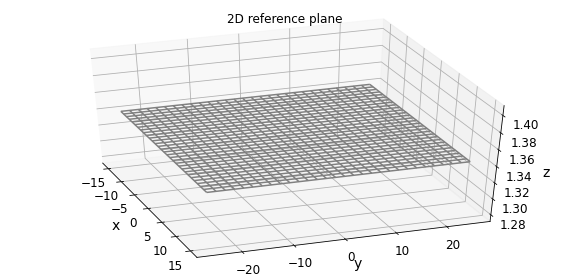

In [6]:
# Plot for a three-dimensional Plane
# this function is currently not used
def z_function(x, y):
    # ax+by+cz = d ---> z = -(ax+by-d)/c
    return  z_mean + 0 * x + 0 * y       

# create a plane with meshgrid (mainly for visualization purpose)
# x_plane = np.linspace(-11, 11, 30)
# y_plane = np.linspace(-21, 21, 30)
x_plane = np.linspace(-15, 15, 30)
y_plane = np.linspace(-25, 25, 30)

X, Y = np.meshgrid(x_plane, y_plane)
Z = z_function(X, Y) # the Z value (height) of the nominal plane is equal to the mean Z value of the point l
#print (X, Y, Z)


plt.figure(figsize=(8, 4))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_wireframe(X, Y, Z, color='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('2D reference plane')

ax.view_init(elev=40,azim=-20) #rotate the graph
save_fig("01_reference_plane")


#-----------------------------------------reference code-----------------------------------------------
# fig = plt.figure()
# ax = plt.axes(projection="3d")
# def z_function(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

# x = np.linspace(-6, 6, 30)
# y = np.linspace(-6, 6, 30)

# X, Y = np.meshgrid(x, y)
# Z = z_function(X, Y)

# fig = plt.figure()
# ax = plt.axes(projection="3d")
# ax.plot_wireframe(X, Y, Z, color='green')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.show()

# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='winter', edgecolor='none')
# ax.set_title('surface');

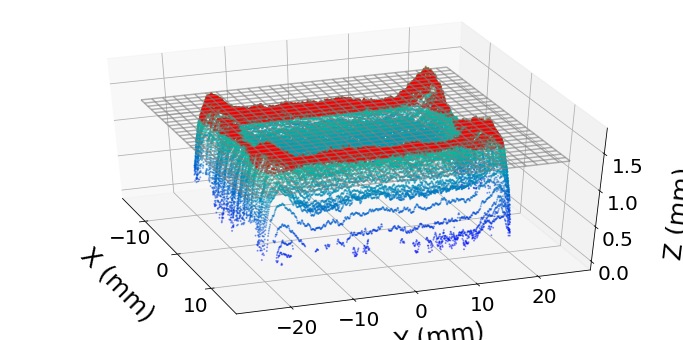

In [7]:
# this will make the plot interactive
# %matplotlib auto
x = points_np_array[:,0]
y = points_np_array[:,1]
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]


plt.figure(figsize=(12, 6))
# plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

ax.plot_wireframe(X, Y, Z, color='gray',  alpha=0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(x, y, z, c=z, cmap='winter', s = 1, alpha=0.4)

points_new = points_np_array[((points_np_array[:,2] > (z_mean-0.05))),:]
x = points_new[:,0]
y = points_new[:,1]
z = points_new[:,2]
ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.2)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
ax.set_zticks([0, 0.5, 1, 1.5, 2])
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)


# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=40,azim=-20) #rotate the graph
# save_fig("02_visualization of 3D point cloud with the reference plane")

### 1.4 Point cloud visualizaiton using plotpy

In [8]:
# # For plotting
# import plotly.io as pio
# import plotly.graph_objects as go
# import chart_studio.plotly as py

# points_np_array_downsampled = np.asarray(downsample_pcd.points)
# print("the points are: \n")
# print(points_np_array)
# #------extract x value of the points-----
# x_down = points_np_array_downsampled[:,0]
# y_down = points_np_array_downsampled[:,1]
# z_down = points_np_array_downsampled[:,2]



# layout = go.Layout(
#     title='Parametric Plot',
#     scene=dict(
#         xaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         ),
#         yaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         ),
#         zaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)'
#         )
#     )
# )


# fig = go.Figure(data=[go.Scatter3d(x=x_down, y=y_down, z=z_down,
#                                    mode='markers')], layout=layout)

# py.iplot(fig, filename='jupyter-parametric_plot')
# fig.show()

## Segmentation: Remove the points below the reference plane

the points below the reference plane are 

### using numpy library

In [9]:
points_segmented = points_np_array[np.where(points_np_array[:,2] > z_mean)] # should be z_mean here

print(points_np_array)
print("the point cloud segmented: ")
print(points_segmented)

[[-10.13915588 -19.27032314   0.5311229 ]
 [-10.13968095 -19.19431511   0.5649312 ]
 [-10.14048379 -19.1195331    0.5907771 ]
 ...
 [ 10.17310155  19.43268697   0.2177512 ]
 [ 10.17420343  19.51052893   0.1713399 ]
 [ 10.17346534  19.58841296   0.1290163 ]]
the point cloud segmented: 
[[ -9.56302014 -17.74887974   1.3458909 ]
 [ -9.56279359 -17.67781856   1.3447723 ]
 [ -9.5634848  -17.60777515   1.344712  ]
 ...
 [  8.66727035  17.74265523   1.374724  ]
 [  8.66658094  17.81269927   1.3746837 ]
 [  8.66716664  17.88435272   1.3585144 ]]


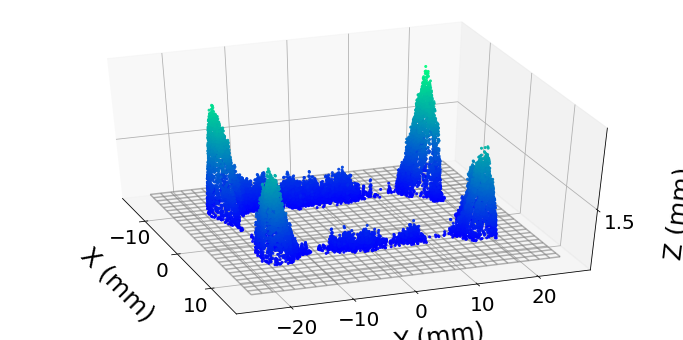

In [10]:
x_seg = points_segmented[:,0]
y_seg = points_segmented[:,1]
z_seg = points_segmented[:,2]



plt.figure(figsize=(12, 6))
# plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, Z, color='gray', alpha = 0.6)
# Data for three-dimensional scattered points, extracted from numpy array
p = ax.scatter3D(x_seg, y_seg, z_seg, c=z_seg, cmap='winter', s = 4, alpha = 0.9); # other cmap options: winter, Greens
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
ax.set_zticks([1, 1.5, 2])
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)


# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=40,azim=-20) #rotate the graph

# save_fig("step3_point cloud below the reference plane are removed")

## Extract the 2D projected points from the segmented cloud

the point cloud projected on the 2D plane: 
[[ -9.56302014 -17.74887974   1.34128463]
 [ -9.56279359 -17.67781856   1.34128463]
 [ -9.5634848  -17.60777515   1.34128463]
 ...
 [  8.66727035  17.74265523   1.34128463]
 [  8.66658094  17.81269927   1.34128463]
 [  8.66716664  17.88435272   1.34128463]]
point_extracted shape: (17510, 3)


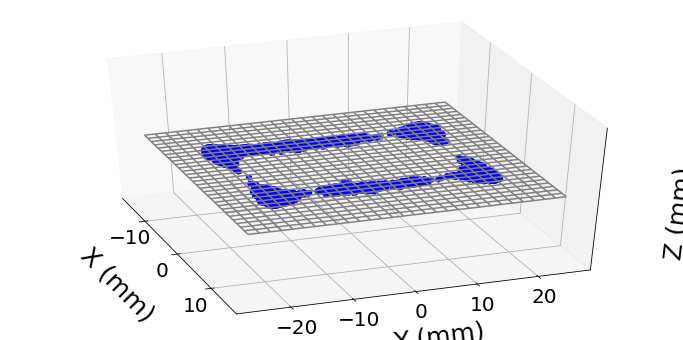

In [11]:
## set the z = z_mean for all the points
point_extracted = points_segmented
point_extracted[:,2] = z_mean
print("the point cloud projected on the 2D plane: ")
print(point_extracted)
print ("point_extracted shape: " + str(point_extracted.shape))


x_2d = point_extracted[:,0]
y_2d = point_extracted[:,1]
z_2d = point_extracted[:,2]



plt.figure(figsize=(12, 6))
# plt.figure()
ax = plt.axes(projection='3d')


ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x_2d, y_2d, z_2d, c=z_2d, cmap='winter'); # other cmap options: winter, Greens
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
ax.set_zticks([1, 1.5, 2])
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)



# plt.title('point cloud projected onto the 2D reference plane')
ax.view_init(elev=40,azim=-20) #rotate the graph
#‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.

# save_fig('step_4 point cloud projected onto the 2D reference plane')

## Convert all points into 2D points

In [12]:
print ("point_extracted number of points: " + str(point_extracted.shape[0]))
point_2D_extracted = np.zeros((point_extracted.shape[0], 2))
point_2D_extracted[:, 0] = point_extracted[:, 0]
point_2D_extracted[:, 1] = point_extracted[:, 1]
print ("point_2D_extracted dimensin: " + str(point_2D_extracted.shape))

point_extracted number of points: 17510
point_2D_extracted dimensin: (17510, 2)


## DBSCAN clustering by Open3D

In [13]:
## produce 2D point cloud with the above numpy array data

# an open3d point cloud object
pcd_2D = o3d.geometry.PointCloud()
pcd_2D.points = o3d.utility.Vector3dVector(point_extracted)


# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
labels = np.array(pcd_2D.cluster_dbscan(eps=0.8, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_2D.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd_2D])

point cloud has 5 clusters


## check points in each clusters

In [14]:
print("the clustered point cloud label are: \n")
print(labels)
print("size of the point cloud 2D extracted: " + str(point_2D_extracted.size))
print("size of the lables: " + str(labels.size))
17510 * 2

the clustered point cloud label are: 

[0 0 0 ... 2 2 2]
size of the point cloud 2D extracted: 35020
size of the lables: 17510


35020

## Downsample the points using voxel grid filter

In [15]:
print("Downsample the 2D point cloud with a voxel of 0.8")
downsample_pcd_2D = pcd_2D.voxel_down_sample(voxel_size=0.5)

o3d.visualization.draw_geometries([downsample_pcd_2D])

Downsample the 2D point cloud with a voxel of 0.8


#### Convert the open3D points to numpy array for further processing

In [16]:
# convert Open3D.o3d.geometry.PointCloud to numpy array
extracted_2D_downsampled = np.asarray(downsample_pcd_2D.points)
# print (extracted_2D_downsampled)

## Using Sklearn DBSCAN clustering

Estimated number of clusters: 5
Estimated number of noise points: 16
Saving figure step5_DBSCAN clustering by SKlearn (black points are noise which do not belong to any cluster)


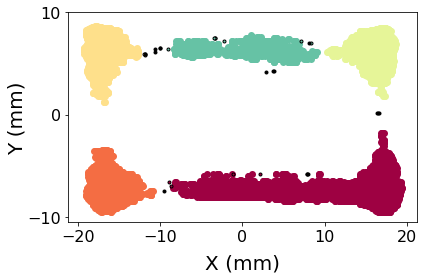

In [159]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import transforms

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.8, min_samples=10).fit(point_2D_extracted)
# db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))


### rotate figure -
# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)


## set colors for differnt labels
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

# colors = ['r','g','b','c','y']

point_clusters = []
cluster = 0 
while cluster < n_clusters_:
    
    class_member_mask = (labels == cluster)
    point_clusters.append(point_2D_extracted[class_member_mask & core_samples_mask])
#     point_clusters.append(extracted_2D_downsampled[class_member_mask & core_samples_mask])
    cluster = cluster + 1

    
    
    
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
#     point_clusters[k] =  point_2D_extracted[class_member_mask & core_samples_mask]
   
    xy = point_2D_extracted[class_member_mask & core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='None', markersize=14, transform= rot + base)

    # these are the points does not belong to either clusters (noise)
    xy = point_2D_extracted[class_member_mask & ~core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, transform= rot + base)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-20, -10, 0 , 10, 20], fontsize = 16) 
plt.yticks([-10, 0, 10], fontsize = 16)


# plt.title('Estimated number of clusters: %d' % n_clusters_)
save_fig("step5_DBSCAN clustering by SKlearn (black points are noise which do not belong to any cluster)")
plt.show()

In [18]:
print("the dimension of the point cloud cluster: " + str(point_clusters[4].shape))

the dimension of the point cloud cluster: (1432, 2)


## Visualize one indivudual point cluster

Saving figure visualization of cluster 4


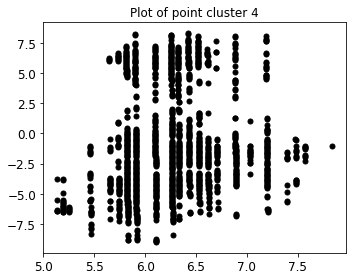

In [19]:
##---- visualize only the point cluster 5
plt.figure(figsize=(5, 4))


plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], '.', markerfacecolor=tuple(col),
        markeredgecolor='k', markersize=10)

plt.title('Plot of point cluster 4')
save_fig("visualization of cluster 4")
plt.show()

## Get the contour of each point cloud clusters

In [20]:
# tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
# # for alpha in np.logspace(np.log10(0.5), np.log10(0.01), num=2):
# for alpha in 0.5,0.4,0.3:
#     print(f"alpha={alpha:.3f}")
#     mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
#         pcd, alpha, tetra_mesh, pt_map)
#     mesh.compute_vertex_normals()
#     o3d.visualization.draw_geometries([mesh])

### Example: using open3d for concave hull fitting

In [21]:
## mesh = o3dtut.get_bunny_mesh()

# o3d.visualization.draw_geometries([pcd])
# alpha = 0.03
# print(f"alpha={alpha:.3f}")
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
#     pcd, alpha)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])

### Example : using alphashape python library to extract contour

<Figure size 720x576 with 0 Axes>

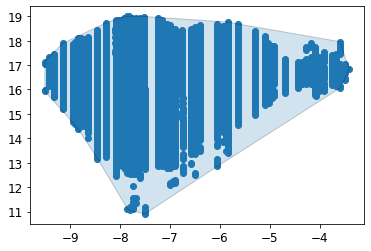

In [22]:
import alphashape
import sys
from descartes import PolygonPatch

#-------------1. using self-optimization of alpha value--------------------------
# alpha = 0.95 * alphashape.optimizealpha(point_clusters[4])
# hull = alphashape.alphashape(point_clusters[4], alpha)
# hull_pts = hull.exterior.coords.xy

# fig, ax = plt.subplots()
# ax.scatter(hull_pts[0], hull_pts[1], color='red') 


#-------------2. using user-defined alpha value--------------------------
alpha_shape = alphashape.alphashape(point_clusters[1], 0.1)
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
ax.scatter(*zip(*point_clusters[1]))

ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
# save_fig("Using alphashape python library to get contour of a point cloud cluster (this was not chosen)")
plt.show()



### Example : (from online)
https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

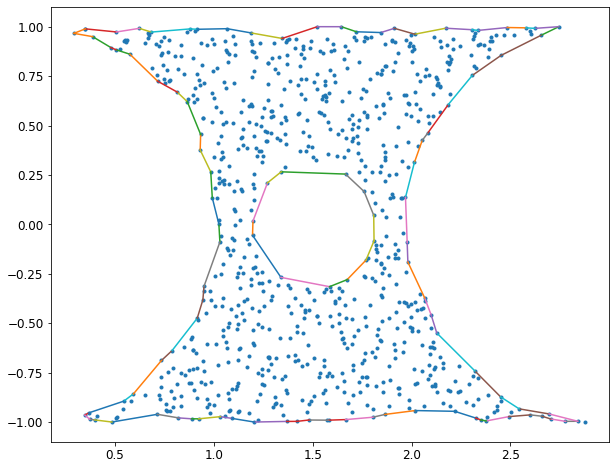

In [23]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle 外接圆
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges


# from matplotlib.pyplot import *

# Constructing the input point data
np.random.seed(0)
x = 3.0 * np.random.rand(2000)
y = 2.0 * np.random.rand(2000) - 1.0
inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0) & ((x - 1.5) ** 2 + y ** 2 > 0.09))
points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.25, only_outer=True)

# Plotting the output
plt.figure(figsize=(10, 8))
plt.axis('equal')
plt.plot(points[:, 0], points[:, 1], '.')
for i, j in edges:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
plt.show()

{(294, 692), (473, 366), (578, 731), (276, 821), (606, 70), (628, 643), (723, 555), (245, 750), (29, 294), (32, 564), (167, 298), (223, 271), (610, 363), (787, 13), (483, 336), (409, 723), (658, 80), (630, 183), (829, 766), (26, 743), (280, 462), (599, 744), (564, 182), (477, 141), (801, 317), (205, 672), (69, 109), (392, 539), (70, 801), (253, 167), (664, 735), (182, 628), (632, 538), (522, 537), (382, 813), (363, 69), (514, 247), (487, 280), (711, 786), (821, 545), (744, 267), (545, 589), (328, 392), (366, 770), (643, 514), (538, 658), (39, 1), (109, 26), (634, 483), (114, 829), (289, 477), (183, 664), (267, 630), (98, 581), (813, 634), (712, 253), (743, 98), (157, 134), (317, 626), (553, 223), (731, 242), (652, 718), (542, 733), (838, 273), (134, 276), (273, 29), (718, 39), (1, 487), (766, 245), (537, 787), (80, 726), (581, 704), (13, 551), (626, 205), (681, 636), (750, 578), (741, 632), (735, 263), (733, 681), (726, 32), (672, 838), (154, 165), (165, 599), (573, 157), (247, 409), (

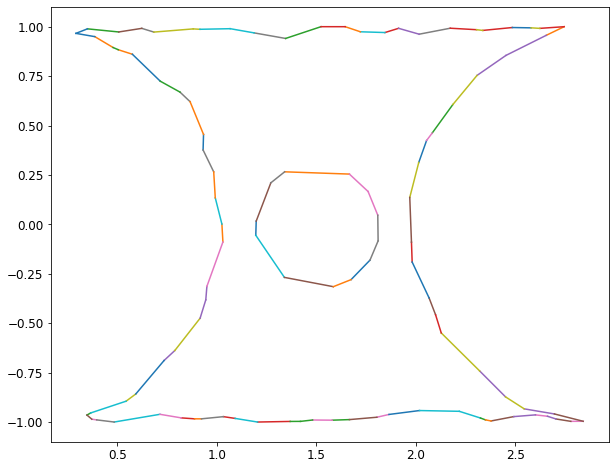

In [24]:
print (edges)
# Plotting the output
plt.figure(figsize=(10, 8))

for i, j in edges:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
plt.show()

### Tuning the parameter for concave hull fitting: alpha
- current value of alpha for fitting: 5 (default)
- for point cloud cluster 1

Saving figure Step6.1 contour of point cloud cluster 1


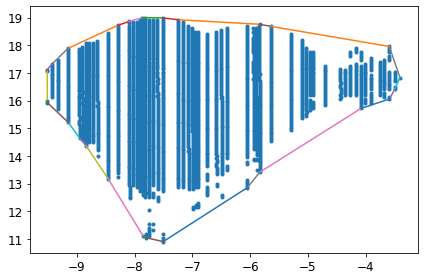

[array([-9.5099091 , -7.24462729]), array([-9.5099091 , -7.80828165]), array([-9.5099091 , -9.51050752]), array([-9.5099091 , -8.83804074]), array([-9.5099091, -5.8371427]), array([-9.5099091, -4.0807922]), array([-9.5099091 , -5.83194513]), array([-9.5099091 , -9.50976375]), array([-9.5099091 , -8.95130951]), array([-9.5099091 , -6.04854025]), array([-9.5099091 , -9.15158739]), array([-9.5099091, -9.5099091]), array([-9.5099091 , -8.28731867]), array([-9.5099091 , -3.49760769]), array([-9.5099091 , -7.50422509]), array([-9.5099091 , -8.09237637]), array([-9.5099091 , -3.59152755]), array([-9.5099091 , -8.45456718]), array([-9.5099091 , -3.40618803]), array([-9.5099091 , -3.58968265]), array([-9.5099091 , -5.64080576]), array([-9.5099091 , -7.86364789]), array([-9.5099091 , -7.51229332]), array([-9.5099091 , -9.51115761]), array([-9.5099091 , -9.14944738]), array([-9.5099091 , -7.85609261]), array([-9.5099091 , -9.42201341])]


[array([-9.50976375, -9.51050752])]


In [25]:
# Constructing the input point data

# points = np.vstack([point_clusters[4][:, 0], point_clusters[4][:, 1].T

# Computing the alpha shape
edges1 = alpha_shape(point_clusters[1], alpha=5, only_outer=True)


vertices_x_cluster_1 = []
vertices_y_cluster_1 = []
vertices_cluster_edge_test = []

# Plotting the output
plt.figure(figsize=(6, 4))
# plt.axis('equal')
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], '.')
for i, j in edges1:
    plt.plot(point_clusters[1][[i, j], 0], point_clusters[1][[i, j], 1])
     
    vertices_x_cluster_1.append(point_clusters[1][[0,j], 0]) # x coordinates of polgon vertices, vector (array)
    vertices_y_cluster_1.append( point_clusters[1][[1, j], 1])  # y coordinates of polgon vertices, vector


vertices_cluster_edge_test.append (point_clusters[1][[1, 2], 0]) 
save_fig("Step6.1 contour of point cloud cluster 1")

plt.show()


print (vertices_x_cluster_1)
print ("\n")
print (vertices_cluster_edge_test)

In [26]:
# print("Show the dimension of the edges: " + edges.shape)
print("print the value of edges: " + str(edges1))

print the value of edges: {(2567, 1555), (905, 998), (3, 2), (87, 183), (2627, 2567), (2491, 2901), (2282, 2491), (2, 1), (48, 87), (1375, 2282), (552, 86), (1, 0), (644, 552), (3007, 3026), (998, 1375), (997, 644), (3034, 3025), (183, 399), (3026, 3034), (2901, 3007), (3025, 2627), (1468, 997), (1555, 1468), (21, 3), (0, 48), (399, 905), (86, 21)}


### for point cloud cluster 2 (visualization with polygon fitting)

Saving figure Step6.2 contour of point cloud cluster 2


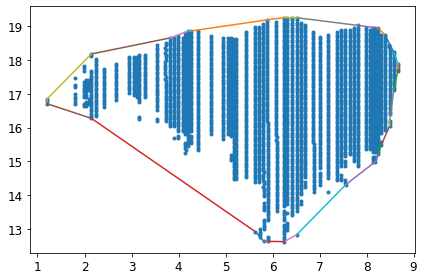

[array([-9.5099091 , -7.24462729]), array([-9.5099091 , -7.80828165]), array([-9.5099091 , -9.51050752]), array([-9.5099091 , -8.83804074]), array([-9.5099091, -5.8371427]), array([-9.5099091, -4.0807922]), array([-9.5099091 , -5.83194513]), array([-9.5099091 , -9.50976375]), array([-9.5099091 , -8.95130951]), array([-9.5099091 , -6.04854025]), array([-9.5099091 , -9.15158739]), array([-9.5099091, -9.5099091]), array([-9.5099091 , -8.28731867]), array([-9.5099091 , -3.49760769]), array([-9.5099091 , -7.50422509]), array([-9.5099091 , -8.09237637]), array([-9.5099091 , -3.59152755]), array([-9.5099091 , -8.45456718]), array([-9.5099091 , -3.40618803]), array([-9.5099091 , -3.58968265]), array([-9.5099091 , -5.64080576]), array([-9.5099091 , -7.86364789]), array([-9.5099091 , -7.51229332]), array([-9.5099091 , -9.51115761]), array([-9.5099091 , -9.14944738]), array([-9.5099091 , -7.85609261]), array([-9.5099091 , -9.42201341])]


[array([-9.50976375, -9.51050752])]


In [27]:
# Computing the alpha shape
edges2 = alpha_shape(point_clusters[2], alpha=5, only_outer=True)


vertices_x_cluster_2 = []
vertices_y_cluster_2 = []
vertices_cluster_edge_test = []

# Plotting the output
plt.figure(figsize=(6, 4))
# plt.axis('equal')
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], '.')
for i, j in edges2:
    plt.plot(point_clusters[2][[i, j], 0], point_clusters[2][[i, j], 1])
     
    vertices_x_cluster_2.append(point_clusters[2][[0,j], 0]) # x coordinates of polgon vertices, vector (array)
    vertices_y_cluster_2.append( point_clusters[2][[1, j], 1])  # y coordinates of polgon vertices, vector


vertices_cluster_edge_test.append (point_clusters[1][[1, 2], 0]) 
save_fig("Step6.2 contour of point cloud cluster 2")

plt.show()

print (vertices_x_cluster_1)
print ("\n")
print (vertices_cluster_edge_test)

## Plot the point cloud clusters and the bounding box (reference plane)

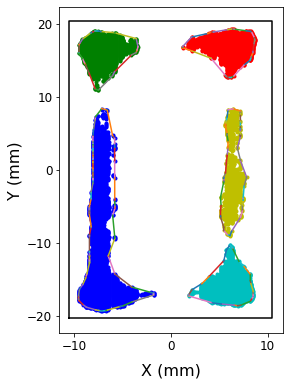

In [28]:
# Computing the alpha shape
edges0 = alpha_shape(point_clusters[0], alpha=4, only_outer=True)
edges2 = alpha_shape(point_clusters[2], alpha=4, only_outer=True)
edges3 = alpha_shape(point_clusters[3], alpha=4, only_outer=True)
edges4 = alpha_shape(point_clusters[4], alpha=4, only_outer=True)

# Plotting the output
plt.figure(figsize=(4, 6))
# plt.axis('equal')
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], 'b.')
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], 'g.')
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], 'r.')
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], 'c.')
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], 'y.')
for i, j in edges0:
    plt.plot(point_clusters[0][[i, j], 0], point_clusters[0][[i, j], 1])
for i, j in edges1:
    plt.plot(point_clusters[1][[i, j], 0], point_clusters[1][[i, j], 1])
for i, j in edges2:
    plt.plot(point_clusters[2][[i, j], 0], point_clusters[2][[i, j], 1])
for i, j in edges3:
    plt.plot(point_clusters[3][[i, j], 0], point_clusters[3][[i, j], 1])
for i, j in edges4:
    plt.plot(point_clusters[4][[i, j], 0], point_clusters[4][[i, j], 1])
    
# Outer boundary
xd=[-10.5, 10.5, 10.5,-10.5,-10.5];
yd=[-20.3,-20.3, 20.3, 20.3,-20.3];




plt.xlabel('X (mm)', fontsize=16, labelpad=10)
plt.ylabel('Y (mm)', fontsize=16, labelpad=5)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10]) 
plt.yticks([-20, -10, 0 , 10, 20])


plt.plot(xd,yd,'k');
# plt.title("The convex area point clusters \n with contours and the bounding box")
# save_fig("step6.3- Point clusters contours and the bounding box")


plt.show()


## Another method for Concave hull (polygon fitting) 
---- This one will be chosen

### 1. ConcaveHull.py from https://gist.github.com/AndreLester/589ea1eddd3a28d00f3d7e47bd9f28fb
http://www.rotefabrik.free.fr/concave_hull/

Advantage: fast, directly give the boundaries of edges with points in numpy array format

In [29]:
'''
Copyright (C) 2018  Andre Lester Kruger

ConcaveHull.py is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.

ConcaveHull.py is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
'''

import bisect
from collections import OrderedDict
import math
#import numpy as np
import matplotlib.tri as tri
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge


class ConcaveHull:
    
    def __init__(self):
        self.triangles = {}
        self.crs = {}
        
    
    def loadpoints(self, points):
        #self.points = np.array(points)
        self.points = points
        
        
    def edge(self, key, triangle):
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        pos = triangle[1].index(-1)
        if pos==0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos==1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos==2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        
    
    def triangulate(self):
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)
        
        self.triangles = {}
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

    def calculatehull(self, tol=50):
        
        self.tol = tol
        
        if len(self.triangles) == 0:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = []    
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()
            
                    

    def polygon(self):
        
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos==1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos==2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.boundary = Polygon(bound.coords)
        
        
        
#if __name__ == '__main__':

### visualization (cluster 0)

- Hyperparameter for tuning: tol (equivalent to alpha value)

Saving figure Step6.4- Get the contour of the point cluster (return the boundary points in red) - Cluster0


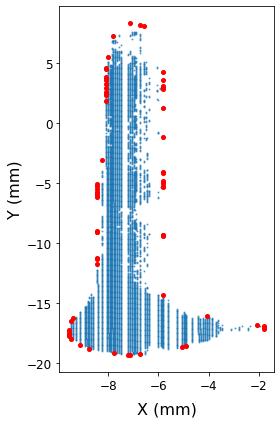

[[ -9.5634848  -17.60777515]
 [ -9.56302014 -17.74887974]
 [ -9.47851699 -17.95959273]
 [ -9.11761151 -18.46083308]
 [ -8.75113822 -18.81763292]
 [ -7.77992328 -19.19316765]
 [ -7.20933058 -19.33870567]
 [ -7.12406684 -19.34029991]
 [ -6.71589772 -19.27917588]
 [ -5.06245858 -18.66787476]
 [ -4.88287537 -18.5976883 ]
 [ -1.79843862 -17.15817805]
 [ -1.79878351 -17.01800267]
 [ -1.799247   -16.87584928]
 [ -2.08671842 -16.79918684]
 [ -4.05136342 -16.0624997 ]
 [ -5.80649212 -14.28080698]
 [ -5.81072562  -9.42281761]
 [ -5.81097803  -9.35038047]
 [ -5.81098954  -9.28051593]
 [ -5.81490425  -5.34086754]
 [ -5.81453252  -5.20086149]
 [ -5.81524029  -4.98866294]
 [ -5.81518631  -4.84785563]
 [ -5.8162692   -4.14618928]
 [ -5.81552418  -4.07646385]
 [ -5.81907176  -1.12638768]
 [ -5.8212472    1.25960566]
 [ -5.82288625   2.87364236]
 [ -5.82280902   2.94393488]
 [ -5.82275968   3.08402917]
 [ -5.82332879   3.57611922]
 [ -5.82416619   4.2779746 ]
 [ -6.57583444   8.15191707]
 [ -6.74090133

In [30]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[0]
ch.loadpoints(pts)
ch.calculatehull(tol = 5)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 6))
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], '.', ms = 2, alpha = 0.6)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 8)

plt.xlabel('X (mm)', fontsize=16, labelpad=10)
plt.ylabel('Y (mm)', fontsize=16, labelpad=5)
# plt.xticks(np.arange(-10, 10, 10))
# plt.xticks([-10, 0, 10]) 
# plt.yticks([-20, -10, 0 , 10, 20])


# plt.title("Boundary point of of the point cluster 0 \n (the boundary points in red)")
save_fig("Step6.4- Get the contour of the point cluster (return the boundary points in red) - Cluster0")
plt.show()

print (boundary_points)
print (boundary_points.shape)

Saving figure Step6.6- Boundary point of of the point cluster 1


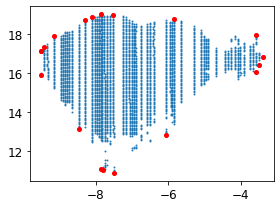

[[-9.51115761 17.12312109]
 [-9.5099091  15.92699988]
 [-8.45456718 13.16732324]
 [-7.85609261 11.12160241]
 [-7.80828165 11.04733916]
 [-7.50422509 10.9021958 ]
 [-6.04854025 12.8521824 ]
 [-3.58968265 16.05817396]
 [-3.49760769 16.4095063 ]
 [-3.40618803 16.83536133]
 [-3.59152755 17.95838493]
 [-5.8371427  18.76033372]
 [-7.51229332 18.99059348]
 [-7.86364789 19.00145195]
 [-8.09237637 18.86245815]
 [-8.28731867 18.72359183]
 [-9.15158739 17.88949919]
 [-9.42201341 17.33394528]
 [-9.51115761 17.12312109]]
(19, 2)


In [31]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[1]
ch.loadpoints(pts)
ch.calculatehull(tol = 5)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 3))
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], '.', ms = 2, alpha = 0.9)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 8)


# plt.title("The bulge area cluster 0 with its polygon edge points in red dots")
save_fig("Step6.6- Boundary point of of the point cluster 1")
plt.show()

print (boundary_points)
print (boundary_points.shape)

Saving figure Step6.7- Boundary point of of the point cluster 2


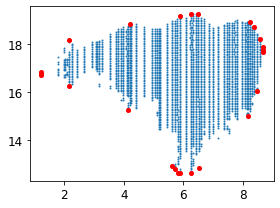

[[ 1.20457517 16.77471972]
 [ 1.20510672 16.70453767]
 [ 2.14603108 16.27315717]
 [ 4.1479929  15.26211891]
 [ 5.63764557 12.91955641]
 [ 5.7235336  12.77801468]
 [ 5.81030009 12.64084099]
 [ 5.89763558 12.6362975 ]
 [ 6.25190999 12.63064761]
 [ 6.51768326 12.83792935]
 [ 8.18934851 14.99510917]
 [ 8.49148276 16.04937152]
 [ 8.66716577 17.67507386]
 [ 8.66727035 17.74265523]
 [ 8.66716664 17.88435272]
 [ 8.57784886 18.23441704]
 [ 8.39270141 18.73729733]
 [ 8.24721216 18.94355361]
 [ 6.51178767 19.24727959]
 [ 6.24557538 19.2499589 ]
 [ 5.89127539 19.18469623]
 [ 4.20088511 18.84873654]
 [ 2.14414704 18.17436726]
 [ 1.20548297 16.84659083]
 [ 1.20457517 16.77471972]]
(25, 2)


In [32]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[2]
ch.loadpoints(pts)
ch.calculatehull(tol = 4)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 3))
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], '.', ms = 2, alpha = 0.9)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 8)


# plt.title("The bulge area cluster 0 with its polygon edge points in red dots")
save_fig("Step6.7- Boundary point of of the point cluster 2")
plt.show()

print (boundary_points)
print (boundary_points.shape)

Saving figure Step6.XX1- Boundary point of of the point cluster 3


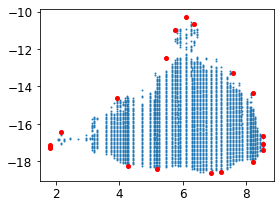

[[  1.83281873 -17.20413106]
 [  1.83310632 -17.27859482]
 [  4.29131868 -18.23168075]
 [  5.20471878 -18.38674281]
 [  6.90431013 -18.6177727 ]
 [  7.21503996 -18.55908345]
 [  8.22068885 -18.00752601]
 [  8.52261663 -17.37297751]
 [  8.52260793 -17.09178682]
 [  8.52229501 -16.66937287]
 [  8.21754395 -14.33755904]
 [  7.57914884 -13.26570792]
 [  6.34044516 -10.64266684]
 [  6.11051199 -10.28934134]
 [  5.7466183  -10.98454376]
 [  5.46991699 -12.46220909]
 [  3.93679379 -14.62413069]
 [  2.17621191 -16.43816938]
 [  1.83288764 -17.13421663]
 [  1.83281873 -17.20413106]]


In [33]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[3]
ch.loadpoints(pts)
ch.calculatehull(tol = 4)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 3))
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], '.', ms = 2, alpha = 0.9)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 8)


# plt.title("The bulge area cluster 0 with its polygon edge points in red dots")
save_fig("Step6.XX1- Boundary point of of the point cluster 3")
plt.show()

print (boundary_points)

Saving figure Step6.XX- Boundary point of of the point cluster 4


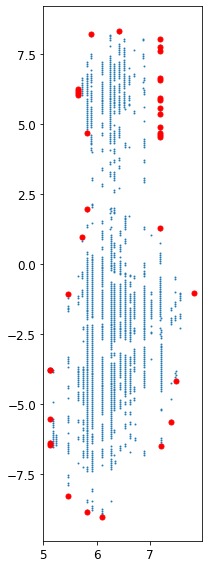

[[ 5.13280152 -3.79432923]
 [ 5.13438692 -5.5532771 ]
 [ 5.13517377 -6.39695784]
 [ 5.13526204 -6.46641838]
 [ 5.46552895 -8.30643884]
 [ 5.829844   -8.86960755]
 [ 6.10913523 -9.0217426 ]
 [ 7.20314377 -6.5004921 ]
 [ 7.39373428 -5.65207365]
 [ 7.4806212  -4.17767376]
 [ 7.83477886 -1.02114569]
 [ 7.1964392   1.30119436]
 [ 7.19272408  4.53408421]
 [ 7.19275363  4.60158672]
 [ 7.19262461  4.67205548]
 [ 7.19238406  4.88352833]
 [ 7.1925382   5.37614297]
 [ 7.19194305  5.58805218]
 [ 7.19141417  5.86750344]
 [ 7.19155852  5.93746618]
 [ 7.1913303   6.56921819]
 [ 7.19055781  6.64127   ]
 [ 7.18995101  7.6234547 ]
 [ 7.19020783  7.76407507]
 [ 7.18967821  8.04589831]
 [ 6.42441581  8.33707352]
 [ 5.90195853  8.20442981]
 [ 5.64395344  6.2389138 ]
 [ 5.64380769  6.16894044]
 [ 5.64429793  6.09874841]
 [ 5.64474885  6.02850673]
 [ 5.8181026   4.6947252 ]
 [ 5.82045795  1.95678652]
 [ 5.73484643  0.97207364]
 [ 5.45896539 -1.06188146]
 [ 5.13280152 -3.79432923]]


In [34]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[4]
ch.loadpoints(pts)
ch.calculatehull(tol = 4)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(3, 8))
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], '.', ms = 2, alpha = 0.9)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 10)


# plt.title("The bulge area cluster 0 with its polygon edge points in red dots")
save_fig("Step6.XX- Boundary point of of the point cluster 4")
plt.show()

print (boundary_points)

### plot the whole picture edges (polygon boundary) with point cloud clusters and bounding box

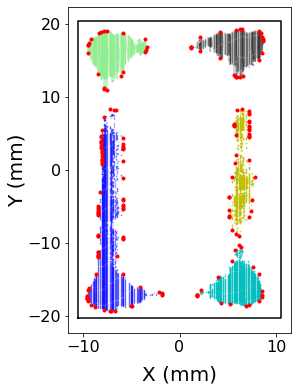

In [35]:
# from ConcaveHull import ConcaveHull

ch0 = ConcaveHull()
ch1 = ConcaveHull()
ch2 = ConcaveHull()
ch3 = ConcaveHull()
ch4 = ConcaveHull()

pts0 = point_clusters[0]
pts1 = point_clusters[1]
pts2 = point_clusters[2]
pts3 = point_clusters[3]
pts4 = point_clusters[4]

ch0.loadpoints(pts0)
ch1.loadpoints(pts1)
ch2.loadpoints(pts2)
ch3.loadpoints(pts3)
ch4.loadpoints(pts4)

ch0.calculatehull(tol = 4)     ## a hyperparameter for tuning
ch1.calculatehull(tol = 4)
ch2.calculatehull(tol = 4)
ch3.calculatehull(tol = 4)
ch4.calculatehull(tol = 4)

boundary_points0 = np.vstack(ch0.boundary.exterior.coords.xy).T
boundary_points1 = np.vstack(ch1.boundary.exterior.coords.xy).T
boundary_points2 = np.vstack(ch2.boundary.exterior.coords.xy).T
boundary_points3 = np.vstack(ch3.boundary.exterior.coords.xy).T
boundary_points4 = np.vstack(ch4.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull

# Plotting the output
plt.figure(figsize=(4, 6))
# plt.axis('equal')
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], 'b.', marker='.', ms = 1, alpha = 0.3)
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], '#90EE90', marker='.', ms = 1, alpha = 0.5)
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], '#0f0f0f80', marker='.', ms = 1, alpha = 0.2)
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], 'c.', marker='.', ms = 1, alpha = 0.7)
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], 'y.', marker='.', ms = 1, alpha = 0.7)

plt.plot(boundary_points0[:, 0], boundary_points0[:, 1], 'r.')
plt.plot(boundary_points1[:, 0], boundary_points1[:, 1], 'r.')
plt.plot(boundary_points2[:, 0], boundary_points2[:, 1], 'r.')
plt.plot(boundary_points3[:, 0], boundary_points3[:, 1], 'r.')
plt.plot(boundary_points4[:, 0], boundary_points4[:, 1], 'r.')

# Outer boundary
xd=[-10.5, 10.5, 10.5,-10.5,-10.5]
yd=[-20.3,-20.3, 20.3, 20.3,-20.3]


plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)



plt.plot(xd,yd,'k');
# plt.title("The bulge area clusters with contours and the bounding box")
# save_fig("Step6.X final- Contour points of the clusters and the bounding box")
plt.show()

Saving figure Step6.9 final- Contour of the clusters and the bounding box


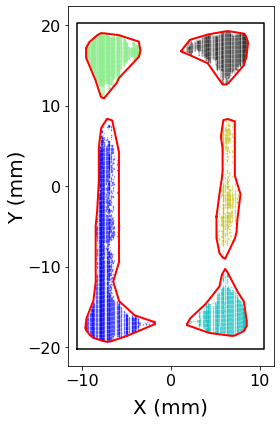

In [36]:
# Plotting the output
plt.figure(figsize=(4, 6))
# plt.axis('equal')

plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], 'b.', ms = 1, alpha = 0.3)
plt.plot(point_clusters[1][:, 0], point_clusters[1][:, 1], '#90EE90', marker='.', ms = 1, alpha = 0.5)
plt.plot(point_clusters[2][:, 0], point_clusters[2][:, 1], '#0f0f0f80', marker='.', ms = 1, alpha = 0.2)
plt.plot(point_clusters[3][:, 0], point_clusters[3][:, 1], 'c.', ms = 1, alpha = 0.3)
plt.plot(point_clusters[4][:, 0], point_clusters[4][:, 1], 'y.', ms = 1, alpha = 0.3)

plt.plot(boundary_points0[:, 0], boundary_points0[:, 1], 'r',linewidth=2)
plt.plot(boundary_points1[:, 0], boundary_points1[:, 1], 'r',linewidth=2)
plt.plot(boundary_points2[:, 0], boundary_points2[:, 1], 'r',linewidth=2)
plt.plot(boundary_points3[:, 0], boundary_points3[:, 1], 'r',linewidth=2)
plt.plot(boundary_points4[:, 0], boundary_points4[:, 1], 'r',linewidth=2)

# Outer boundary
xd=[-10.5, 10.5, 10.5,-10.5,-10.5]
yd=[-20.3,-20.3, 20.3, 20.3,-20.3]

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)


plt.plot(xd,yd,'k');
# plt.title("The bulge area clusters with contours and the bounding box")
save_fig("Step6.9 final- Contour of the clusters and the bounding box")
plt.show()

# Tool path generation

## polyline.py from OpenLMD

## mlabplot.py from OpenLMD

## Contours.py from OpenLMD

# Polygon infill path generate

https://stackoverflow.com/questions/61853250/polygon-infill-path-generate

https://stackoverflow.com/questions/15668149/polygon-infill-algorithm

https://github.com/Tannz0rz/Mandoline

https://www.mathworks.com/matlabcentral/answers/158900-plotting-zigzag-in-a-2d-contour

https://github.com/nahyunkwon/gcode-modification/blob/87e896818704765201d1f3bcf8604f44d23338fa/adhesion_structure.py

# 1. Python inpolygon function
- Need to find a suitable function performing "inpolygon" equivalent as matlab
- Matlab inpolygons function:  
   - It allows the input polygon vertices to describe multiple NaN-delimited polygons. 
   - The polygons can also include holes.  
   - returns true/ false to tell if the points are lie in the polygon

## 1.1 Method one - matplotlib import path
https://stackoverflow.com/questions/31542843/inpolygon-for-python-examples-of-matplotlib-path-path-contains-points-method

In [37]:
from matplotlib import path
p = path.Path([(0,0), (0, 1), (1, 1), (1, 0)])  # square with legs length 1 and bottom left corner at the origin (CW)
p.contains_points([(.5, .5)])

array([ True])

In [38]:
# use a numpy array of points as well:
points = np.array([.5, .5]).reshape(1, 2)
# >>> points
# array([[ 0.5,  0.5]])
p.contains_points(points)

array([ True])

#### Example

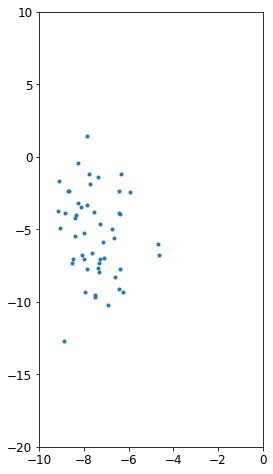

In [39]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(50,2) ; # dimension 250 x 2
xy_points_random[:,0] = xy_points_random[:,0] - 7.5
xy_points_random[:,1] = xy_points_random[:,1] * 3 - 5

plt.figure(figsize=(4, 8))
plt.plot(xy_points_random[:, 0], xy_points_random[:, 1], '.')
plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.show()

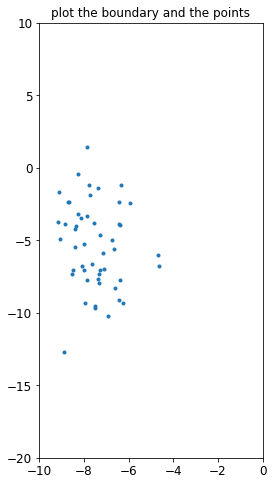

In [40]:
# create a polygon path with 'boundary_points' generated before (one of the hole)
p = path.Path(boundary_points)

plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0], xy_points_random[:, 1], '.')
plt.plot(boundary_points[:, 0], boundary_points[:, 1])
plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("plot the boundary and the points")
plt.show()

In [41]:
## Determine whether each point lies inside or on the edge of the polygon area.
# point_in = []
point_in = p.contains_points(xy_points_random)
print (point_in)
print (point_in.shape)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
(50,)


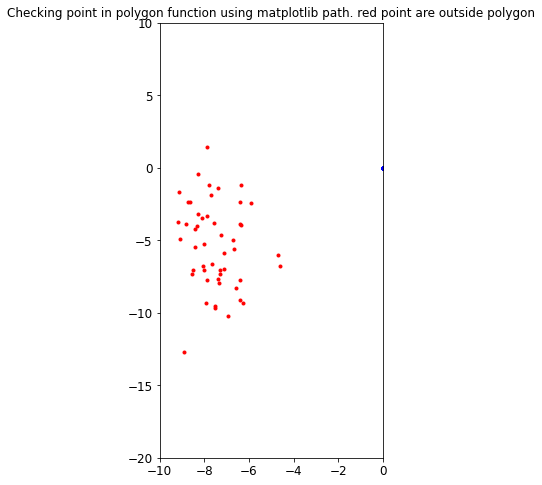

In [42]:
## visualize the graph
# Plotting the output
plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0]*point_in, xy_points_random[:, 1]*point_in, 'b.')
plt.plot(xy_points_random[:, 0]*(~point_in), xy_points_random[:, 1]*(~point_in), 'r.')

plt.plot(boundary_points[:, 0], boundary_points[:, 1])

plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("Checking point in polygon function using matplotlib path. red point are outside polygon")
plt.show()

## Convert this method to the matlab inpolygon equivalent
###  __Disadvantage__:  
- cannot return if the point is on the edge of the polygon
- difficult to use if polygon contains holes


In [43]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

In [44]:
xv = np.array([0.5,0.2,1.0,0,0.8,0.5])
yv = np.array([1.0,0.1,0.7,0.7,0.1,1])
xq = np.array([0.1,0.5,0.9,0.2,0.4,0.5,0.5,0.9,0.6,0.8,0.7,0.2])
yq = np.array([0.4,0.6,0.9,0.7,0.3,0.8,0.2,0.4,0.4,0.6,0.2,0.6])
print(inpolygon(xq, yq, xv, yv))

[False False False  True  True  True False False False  True  True  True]


## Method 2 - Shapely
https://gis.stackexchange.com/questions/170264/python-point-in-polygon-boundary-and-vertex-check-ray-casting

https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates

In [45]:
from shapely.geometry import Point, Polygon,LinearRing, MultiPoint

## create a polygon object using 'boundary_points'
polygon = Polygon(boundary_points)

LINEARRING (5.132801519 -3.794329233, 5.134386919 -5.553277099, 5.135173771 -6.396957836, 5.135262039 -6.466418378, 5.46552895 -8.306438842, 5.829844005 -8.86960755, 6.109135227 -9.021742599, 7.203143769 -6.500492099, 7.393734281 -5.652073647, 7.480621199 -4.177673763, 7.834778857 -1.02114569, 7.196439205 1.301194357, 7.192724081 4.534084207, 7.192753626 4.60158672, 7.192624615 4.67205548, 7.192384056 4.883528325, 7.1925382 5.376142971, 7.191943052 5.588052181, 7.191414173 5.867503443, 7.191558518 5.937466182, 7.191330298 6.569218185, 7.190557805 6.64127, 7.189951006 7.623454697, 7.190207832 7.764075072, 7.189678206 8.045898308, 6.424415808 8.337073518, 5.901958532 8.204429813000001, 5.643953441 6.238913801, 5.643807691 6.168940442, 5.644297932 6.098748407, 5.64474885 6.02850673, 5.818102596 4.694725196, 5.820457946 1.95678652, 5.734846431 0.972073637, 5.458965387 -1.061881461, 5.132801519 -3.794329233)


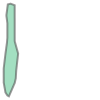

In [46]:
# boundary of the polygon = LinearRing
linearring = LinearRing(list(polygon.exterior.coords))
print (linearring)
polygon

In [47]:
# contains
print (polygon.contains(linearring)) 
print (polygon.touches(linearring))
# polygon.intersect(linearring) #### polygon does not have intersect function, only lines can intersect

False
True


In [48]:
# a vertex 
point = Point(-9.563484803, -17.60777515)
print (polygon.contains(point))
print (polygon.touches(point))   ### for point on the edge of polygon, it only means touch , not contain
# polygon.intersect(point)

False
False


In [49]:
linearring.contains(point)

False

## Visualzation

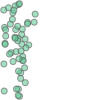

In [50]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(50,2) ; # dimension 250 x 2

xy_points_random[:,0] = xy_points_random[:,0] - 7.5
xy_points_random[:,1] = xy_points_random[:,1] * 3 - 5

points = MultiPoint(xy_points_random)

points

In [51]:
## Determine whether each point lies inside or on the edge of the polygon area.
## --- this will only return one value-----
point_in = polygon.contains(points)
point_on_edge = polygon.touches(points)
##---- the correct way---------
point_in_list = []
for point in points:
    point_in_list.append(polygon.contains(point))

point_in_array = np.array(point_in_list)
print (point_in_list)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


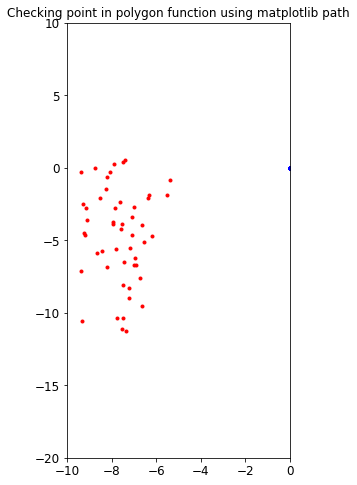

In [52]:
## visualize the graph
# Plotting the output
plt.figure(figsize=(4, 8))

plt.plot(xy_points_random[:, 0]*point_in_array, xy_points_random[:, 1]*point_in_array, 'b.')
plt.plot(xy_points_random[:, 0]*(~point_in_array), xy_points_random[:, 1]*(~point_in_array), 'r.')

plt.plot(boundary_points[:, 0], boundary_points[:, 1])

plt.xlim([-10, 0])
plt.ylim([-20, 10])
plt.title("Checking point in polygon function using matplotlib path")
plt.show()

### Summary
- Due to more robust and user-friendly functionalities, Shapely is chosen

## Polygon with hole (shapely)

- given __outer__ as a plain Polygon and __inners__ as a list of plain Polygons (each of them contained in outer) :

- Polygons

class Polygon(shell[, holes=None])
The Polygon constructor takes two positional parameters. The first is an ordered sequence of (x, y[, z]) point tuples and is treated exactly as in the LinearRing case. The second is an optional unordered sequence of ring-like sequences specifying the interior boundaries or “holes” of the feature.



## __figures.py__ -- an utility function downloaded from shapely.figures.py

https://raw.githubusercontent.com/Toblerity/Shapely/master/docs/code/figures.py

In [53]:
from math import sqrt
from shapely import affinity

GM = (sqrt(5)-1.0)/2.0
W = 8.0
H = W*GM
SIZE = (W, H)

BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

def plot_line(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

def plot_coords(ax, ob, color=GRAY, zorder=1, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, 'o', color=color, zorder=zorder, alpha=alpha)

def color_isvalid(ob, valid=BLUE, invalid=RED):
    if ob.is_valid:
        return valid
    else:
        return invalid

def color_issimple(ob, simple=BLUE, complex=YELLOW):
    if ob.is_simple:
        return simple
    else:
        return complex

def plot_line_isvalid(ax, ob, **kwargs):
    kwargs["color"] = color_isvalid(ob)
    plot_line(ax, ob, **kwargs)

def plot_line_issimple(ax, ob, **kwargs):
    kwargs["color"] = color_issimple(ob)
    plot_line(ax, ob, **kwargs)

def plot_bounds(ax, ob, zorder=1, alpha=1):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color=BLACK, zorder=zorder, alpha=alpha)

def add_origin(ax, geom, origin):
    x, y = xy = affinity.interpret_origin(geom, origin, 2)
    ax.plot(x, y, 'o', color=GRAY, zorder=1)
    ax.annotate(str(xy), xy=xy, ha='center',
                textcoords='offset points', xytext=(0, 8))

def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")

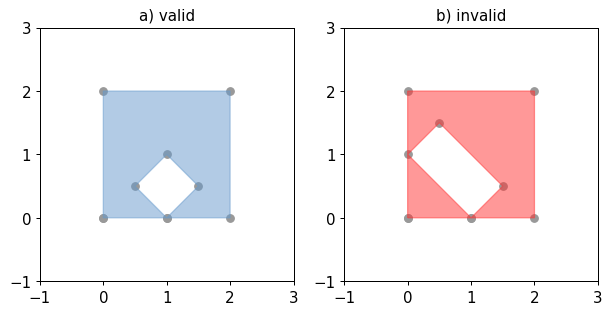

In [54]:
from matplotlib import pyplot
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch


fig = pyplot.figure(1, figsize=SIZE, dpi=90)

# 1: valid polygon
ax = fig.add_subplot(121)

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1, 0), (0.5, 0.5), (1, 1), (1.5, 0.5), (1, 0)][::-1]
polygon = Polygon(ext, [int])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('a) valid')

set_limits(ax, -1, 3, -1, 3)

#2: invalid self-touching ring
ax = fig.add_subplot(122)
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(1, 0), (0, 1), (0.5, 1.5), (1.5, 0.5), (1, 0)][::-1] # [::-1] CCW direction
polygon = Polygon(ext, [int])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('b) invalid')

set_limits(ax, -1, 3, -1, 3)

pyplot.show()


## Testing with our example -- Plot the polygon with clustered bulge area as holes

In [55]:
def plot_filled_polygons(polygons, facecolour='green', edgecolour='black', linewidth=1, alpha=0.5):
        """
        This function plots a series of shapely polygons but fills them in

        Args:
            ax_list: list of axes
            polygons: list of shapely polygons

        Author: FJC
        """
        from shapely.geometry import Polygon
        from descartes import PolygonPatch
        from matplotlib.collections import PatchCollection

        print('Plotting the polygons...')

        #patches = []
        for key, poly in polygons.items():
            this_patch = PolygonPatch(poly, fc=facecolour, ec=edgecolour, alpha=alpha)
            self.ax_list[0].add_patch(this_patch)

In [56]:
# print (boundary_points0)

Saving figure Step7


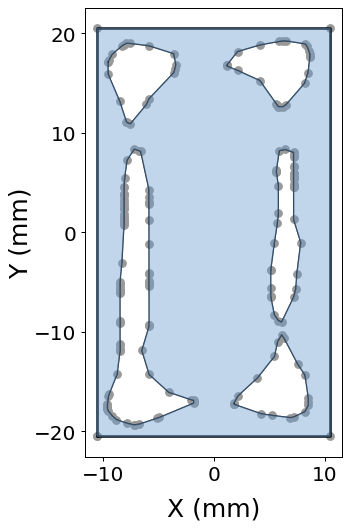

In [57]:
fig = plt.figure(1, figsize=(4, 6), dpi=90)

# 1: valid polygon
# ax = fig.add_subplot(121)
ax = plt.axes()

# Define exterior boundary CCW direction
ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
## Define interior boundaries
## ---- boundary_points0, boundary_points1, boundary_points２,boundary_points3, boundary_points4
# boundary_points0 = boundary_points0[::-1]
polygon = Polygon(ext, [boundary_points0[::-1], boundary_points1[::-1], boundary_points2[::-1], boundary_points3[::-1], boundary_points4[::-1]])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.interiors[1])
plot_coords(ax, polygon.interiors[2])
plot_coords(ax, polygon.interiors[3])
plot_coords(ax, polygon.interiors[4])
plot_coords(ax, polygon.exterior)

plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=2, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.4, zorder=2)
ax.add_patch(patch)


plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)


save_fig("Step7")
# ax.set_title('Plot of Polygon with Holes')


In [58]:
## Testing the points
myPoint = Point(-7.5, -18)
print(myPoint.within(polygon))  # returns 'False'
myPoint2 = Point(0, 0)
print(myPoint2.within(polygon))  # returns 'True'
myPoint３ = Point(5, 0)
print(myPoint3.within(polygon))  # returns 'True'

False
True
True


In [59]:
list(polygon.exterior.coords)

[(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]

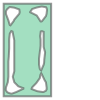

In [60]:
# jupyter notebook is able to visualize directly
polygon

In [61]:
# list(polygon.interiors[0].coords)

### Check Points in holes and polygon

Saving figure Step8-Check Points inide or outside polygons


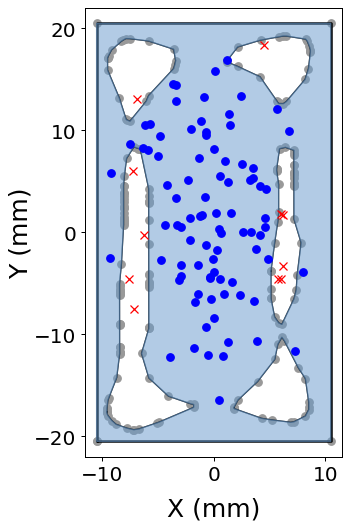

In [62]:
## generate some random points
# np.random.seed(1)
xy_points_random = np.random.randn(100,2) ; # dimension 250 x 2

xy_points_random[:,0] = xy_points_random[:,0]*4
xy_points_random[:,1] = xy_points_random[:,1]*8

points = MultiPoint(xy_points_random)


## Determine whether each point lies inside or on the edge of the polygon area.
##---- the correct way---------
point_in_list = []
for point in points:
    point_in_list.append(polygon.contains(point))
    
point_out_list = []
for point in points:
    point_out_list.append(~polygon.contains(point))

# point_touch_list = []
# for point in points:
#     point_touch_list.append(polygon.touches(point))

# for point in points:
#     point_in_list.append(point.within(polygon))
    
point_in_array = np.array(point_in_list)
point_out_array = np.array(point_out_list)

#----------------------------------------------------visualization----------------------------------------------------------------------------------
fig = pyplot.figure(1, figsize=(4,6), dpi=90)

ax = plt.axes()
# ax = fig.add_subplot(121)

# Define exterior boundary CCW direction
ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
## Define interior boundaries
## ---- boundary_points0, boundary_points1, boundary_points２,boundary_points3, boundary_points4
# polygon = Polygon(ext, [boundary_points0[::-1], boundary_points1[::-1], boundary_points2[::-1], boundary_points3[::-1], boundary_points4[::-1]])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.interiors[1])
plot_coords(ax, polygon.interiors[2])
plot_coords(ax, polygon.interiors[3])
plot_coords(ax, polygon.interiors[4])
plot_coords(ax, polygon.exterior)

plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=2, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

i = 0
for point in point_in_array:
    if point == True:
        plt.plot(xy_points_random[i, 0], xy_points_random[i, 1], 'bo')
    else:
        plt.plot(xy_points_random[i, 0], xy_points_random[i, 1], 'rx')
    i  = i+1
        
# plt.plot(xy_points_random[:, 0]*point_in_array, xy_points_random[:, 1]*point_in_array, 'bo')
# plt.plot((xy_points_random[:, 0]*(~point_in_array))  , (xy_points_random[:, 1]*(~point_in_array)) , 'rx')


patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)

save_fig("Step8-Check Points inide or outside polygons")

# ax.set_title('Blue points - inside polygon \n Red points - outside polygon or in holes')

# 2. Line In Polygon 
### -- looks at a straight line and a closed polygon and determines which segments of the line are located inside the polygon.

### MatLab Equivalent:
- [anyIn, inSegment, outSegment] = lineinpolygon(x1, y1, x2, y2, xv, yv)
- Input variables:

   - x1:         x coordinate of line starting point

   - y1:         y coordinate of line starting point

   - x2:         x coordinate of line ending point

   - y2:         y coordinate of line ending point

   - xv:         x coordinates of vertices of polygon

   - yv:         y coordinates of vertices of polygon

- Output variables:

   - anyIn:      true if any portion of the line is located in the polygon

   - inSegment:  n x 2 [x y] array of line segments located inside the
               polygon.  Segments are separated by NaNs.

   - outSegment: n x 2 [x y] array of line segments located outside the
               polygon.  Segments are separated by NaNs.


## 2.1 determine the line and polygon intersection point
And also the vertices of the edge of the polygon where line intersects

https://gis.stackexchange.com/questions/339409/find-the-vertices-of-the-edge-of-the-polygon-where-line-intersects-using-shapely

In [63]:
from shapely.wkt import loads
lin = loads('LineString (289.63171806167395061 -200.22555066079294761, 380.69030837004402201 -65.28898678414094547)')
pol = loads('Polygon ((112.23259911894263041 -229.94933920704846742, 178.75726872246687549 -113.4132158590308137, 309.44757709251092592 -114.35682819383258391, 376.44405286343607031 -230.42114537444933831, 305.67312775330390195 -344.59823788546259493, 176.39823788546246419 -345.07004405286346582, 112.23259911894263041 -229.94933920704846742))')

# the LinearRing
from shapely.geometry import LineString
polin = LineString(list(pol.exterior.coords))

# intersection 
pt = polin.intersection(lin)
print(pt.wkt)


POINT (327.0268317294637 -144.8110298888352)


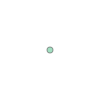

In [64]:
from shapely.geometry import Point
point = Point(327.0268317294637,-144.8110298888352)
point

- iterate through the edges of the LinearRing of the polygon
- Now using Determine if Shapely point is within a LineString/MultiLineString 

(using the answer of Mike T using the distance with an appropriate threshold 
because there are floating point precision errors when finding a point on a line)

In [65]:
# iterate through the edges to determine if Shapely point is within
points = list(polin.coords)
for i,j in zip(points, points[1:]):
   if LineString((i,j)).distance(pt) < 1e-8:
       print(i,j)
# (309.4475770925109, -114.35682819383258) (376.44405286343607, -230.42114537444934)

(309.4475770925109, -114.35682819383258) (376.44405286343607, -230.42114537444934)


### Implementation in our scenario

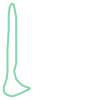

In [66]:
line_example = LineString([(-5, -20), (-5.1, 20)])

poly_lines_exterior = LineString(list(polygon.exterior.coords))
poly_lines_holes_0 = LineString(list(polygon.interiors[0].coords))
poly_lines_holes_1 = LineString(list(polygon.interiors[1].coords))
poly_lines_holes_0

MULTIPOINT (-5.012282407186927 -15.08703712522939, -5.003388029421077 -18.64478823156891)


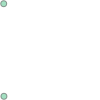

In [67]:
intersection_point = poly_lines_holes_0.intersection(line_example)
print(intersection_point.wkt)
intersection_point

In [68]:
from shapely.geometry import MultiLineString
# poly_lines = MultiLineString
# poly_lines = [poly_lines_holes_0, poly_lines_holes_1]


# intersection_point = poly_lines.intersection(line_example)  ## this does not work
# print(intersection_point.wkt)
# intersection_point
print(list(polygon.exterior.coords))
tuple(list(polygon.exterior.coords))


[(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]


((-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5))

In [69]:
poly_lines = [1]
poly_lines = list(polygon.exterior.coords)

for interior in polygon.interiors: 
    poly_lines.append(list(interior.coords))
#     print (list(interior.coords))
#     print ("\n")

In [70]:
polygon_string = polygon.boundary
polygon_string  ## type is MultiLineString
print (polygon_string)

MULTILINESTRING ((-10.5 -20.5, 10.5 -20.5, 10.5 20.5, -10.5 20.5, -10.5 -20.5), (-9.563484803 -17.60777515, -9.563050549 -17.32317266, -9.562946048000001 -17.25528595, -9.479487978 -16.47694119, -9.391320903 -16.19831782, -8.692026223999999 -14.24323277, -8.430800783 -11.9150651, -8.431330598000001 -11.84282633, -8.431104618999999 -11.77279364, -8.431239261 -11.70301736, -8.431431442999999 -11.28053469, -8.432243388 -11.21056001, -8.433763834000001 -9.096728881000001, -8.434214752000001 -9.026487204, -8.434144440000001 -8.956582716, -8.436751781 -6.142806693, -8.43677576 -6.002404266, -8.436960148000001 -5.863118398, -8.437223274999999 -5.720836693, -8.437499046999999 -5.510747428, -8.437711748 -5.22867673, -8.437665414 -5.018369815, -8.266402065999999 -3.055054607, -8.075370502 0.73404204, -8.075564515 0.946237627, -8.075723902 1.155397275, -8.076342351999999 1.296058663, -8.076223816000001 1.505751217, -8.076762302000001 1.858143052, -8.077243371 2.347575652, -8.077373380999999 2.418

In [71]:
## Bounding box
polygon_string.bounds

(-10.5, -20.5, 10.5, 20.5)

In [72]:
polygon.bounds

(-10.5, -20.5, 10.5, 20.5)

Access the members of a MultiLineString object

- Its members are instances of LineString and are accessed via the geoms property or via the iterator protocol using in or list().

In [73]:
len(polygon_string.geoms)

6

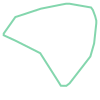

In [74]:
polygon_string.geoms[3]

### Find intersection point for a random line with the given polygon with holes

MULTIPOINT (5.005434782608695 -20.5, 5.094565217391304 20.5)
MULTIPOINT (5.079992385580981 13.79649736725153, 5.091360251393237 19.0257156408892)
MULTIPOINT (5.010100644041152 -18.35370374107048, 5.021533710350291 -13.09449323886593)
MULTIPOINT (5.005434782608695 -20.5, 5.094565217391304 20.5, 5.079992385580981 13.79649736725153, 5.091360251393237 19.0257156408892, 5.010100644041152 -18.35370374107048, 5.021533710350291 -13.09449323886593)


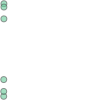

In [75]:
line_example = LineString([(5, -23), (5.1, 23)])
# line_example2 = LineString([(5, -23), (5, 23)])

points = []
for lines in polygon_string.geoms:
    if lines.intersection(line_example):
        intersection_point = lines.intersection(line_example) ## returns MultiPoints object
        print (intersection_point)
        for point in intersection_point.geoms:
            points.append(point)
        

points = tuple(points)
intersection_multipoint = MultiPoint(points)   
print(intersection_multipoint)
intersection_multipoint

In [76]:
len(polygon_string.geoms)

6

## 2.2 Line polygon segmentation

- Developing the python function for line in polygon 

In [77]:
def LinePolygonIntersectionPoints(input_line, polygon):
    '''
    Functionality:
        Return the line and polygon intersection points
    
    Input variable:
        - line: shapely LineString object, example LineString([(x1, y1), (x2, y2)])
        - polygon: shapely Polygon object, contains exterior and interiors vertices (holes)
        
        example: list(polygon.exterior.coords)
             [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)]
        polygon = Polygon(ext, [boundary_points0[::-1], boundary_points1[::-1], boundary_points2[::-1], boundary_points3[::-1], boundary_points4[::-1]])
    
    
    Output:
        - intersection_multipoint: a MultiPoint object containing all the intersection point.

    '''
     
    
    #---------STEP 1:--------------------
    #---Find Intersection Point----------
    #------------------------------------
    ## empty list to store the intersection point, 
    ## a list of Point object
    list_points = [] 
    
    # -------get the boundary points of the polygon ----------------
    polygon_string = polygon.boundary  ## type is MultiLineString

    # iterate each edge lines in the polygon
    for edges in polygon_string.geoms:
        if edges.intersection(input_line): # if intersection point exists
            intersection_point = edges.intersection(input_line) ## intersection_point is a MultiPoints object
#             print (intersection_point)
            # iterate each point in this MultiPoint object
            for point in intersection_point.geoms:
                # append the point to the list
                list_points.append(point)
    
    # convert the point list to a tuple
    list_points = tuple(list_points)
    # create a MultiPoint Object to return all the intersection points
    intersection_multipoint = MultiPoint(list_points)   
    
    print(intersection_multipoint)
    
    return intersection_multipoint                

MULTIPOINT (5.005434782608695 -20.5, 5.094565217391304 20.5, 5.079992385580981 13.79649736725153, 5.091360251393237 19.0257156408892, 5.010100644041152 -18.35370374107048, 5.021533710350291 -13.09449323886593)


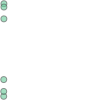

In [78]:
intersection_points = LinePolygonIntersectionPoints(line_example, polygon)
intersection_points

In [79]:
# intersection_points_xxx = LinePolygonIntersectionPoints(line_example3, polygon)

In [80]:
# intersection_points_xxx.geoms

In [81]:
intersection_points.geoms[0]
print(intersection_points.geoms[0])

POINT (5.005434782608695 -20.5)


In [82]:
polygon.interiors[0].coords

In [83]:
intersection_points.geoms[0].coords

### visualize polygon - line intersection

Saving figure Step9-Line-polygon intersection points


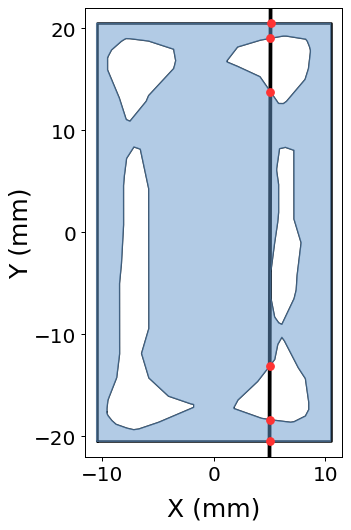

In [84]:
#----visualization
fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()


## Define interior boundaries
## ---- boundary_points0, boundary_points1, boundary_points２,boundary_points3, boundary_points4
# polygon = Polygon(ext, [boundary_points0[::-1], boundary_points1[::-1], boundary_points2[::-1], boundary_points3[::-1], boundary_points4[::-1]])
##--------------------------plot the polygon and its boundary-----------------------------------------------
# plot_coords(ax, polygon.interiors[0])
# plot_coords(ax, polygon.interiors[1])
# plot_coords(ax, polygon.interiors[2])
# plot_coords(ax, polygon.interiors[3])
# plot_coords(ax, polygon.interiors[4])
# plot_coords(ax, polygon.exterior)

plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=2, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)


#----------------------plot the example line------------------------------------------------------------
plot_line(ax, ob=line_example, color=BLACK, zorder=1, linewidth=3, alpha=1)


#----------------------plot the intersection point----------------------------------------------------------
xs = [point.x for point in intersection_points.geoms]
ys = [point.y for point in intersection_points.geoms]
ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        
    
    
patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)



# ax.set_title('Line-polygon intersection points')
save_fig("Step9-Line-polygon intersection points")

In [85]:
line_example.coords[1]

(5.1, 23.0)

In [86]:
line_example.coords

In [87]:
intersection_points.geoms[0].coords[:]
list(intersection_points.geoms[0].coords) # equivalent

[(5.005434782608695, -20.5)]

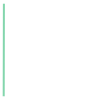

In [88]:
line_seg1 = LineString([intersection_points.geoms[0],intersection_points.geoms[1]])
line_seg1

## sorts the rows of intPoints in ascending order based on the elements in the first column

https://www.kite.com/python/answers/how-to-sort-the-rows-of-a-numpy-array-by-a-column-in-python

In [89]:
list_point_coord = []

for point in intersection_points.geoms:
    list_point_coord.append(point.coords[0])

array_point_coord = np.array(list_point_coord)    
print (array_point_coord) 
print (array_point_coord.shape)

[[  5.00543478 -20.5       ]
 [  5.09456522  20.5       ]
 [  5.07999239  13.79649737]
 [  5.09136025  19.02571564]
 [  5.01010064 -18.35370374]
 [  5.02153371 -13.09449324]]
(6, 2)


In [90]:
# sort the array based on the second colum -- ascending order
sorted_point = array_point_coord[np.argsort(array_point_coord[:, 1])]
# sorted_point = array_point_coord.argsort(axis = 0)
## for descending order:
## array.argsort()[::-1]

print (sorted_point)
print (sorted_point.shape)

[[  5.00543478 -20.5       ]
 [  5.01010064 -18.35370374]
 [  5.02153371 -13.09449324]
 [  5.07999239  13.79649737]
 [  5.09136025  19.02571564]
 [  5.09456522  20.5       ]]
(6, 2)


[<shapely.geometry.point.Point object at 0x7f75900e80b8>, <shapely.geometry.point.Point object at 0x7f75900e8cc0>, <shapely.geometry.point.Point object at 0x7f75900e8898>, <shapely.geometry.point.Point object at 0x7f75900e86a0>, <shapely.geometry.point.Point object at 0x7f75900e8a90>, <shapely.geometry.point.Point object at 0x7f7590121748>]


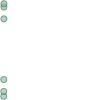

In [91]:
## Convert the sorted array into the MultiPoint
list_point_coord = []

for point in sorted_point:
#     print (point) ## each point is a list
#     print (tuple(point))
    point_ = Point (tuple(point))
    list_point_coord.append(point_)
    
print (list_point_coord)

sorted_multi_point = MultiPoint(tuple(list_point_coord))
sorted_multi_point

### Implement the sorting multi point function 

In [92]:
def sort_MultiPoint(multipoint, ascending = True, axis = 1):
    '''
    This function sort the Shapely MultiPoint Object
    
    Input/argument:
        - multipoint: a shapely multipoint object
        - ascending: Ture or False (descending order)
        - axis 0 or 1 or None, optional, default 1
          (sort the array based on the first or second colum)
          
          
    Return : the multipoint object sorted
    '''
    
    # an temp empty list storing each points' (x,y) coordinate
    list_point_coord = []

    for point in multipoint.geoms:
        list_point_coord.append(point.coords[0]) # append the coordinate to the list

    # convert the list to numpy array
    array_point_coord = np.array(list_point_coord)    
#     print (array_point_coord) 
#     print (array_point_coord.shape)

    if (ascending==True):
        if (axis == 1):
            # sort the array based on the second colum -- ascending order
            sorted_point = array_point_coord[np.argsort(array_point_coord[:, 1])]
        if (axis == 0):
            sorted_point = array_point_coord[np.argsort(array_point_coord[:, 0])]
    else:
        if (axis == 1):
            # sort the array based on the second colum -- descending order
            sorted_point = array_point_coord[np.argsort(array_point_coord[:, 1])[::-1]]
        if (axis == 0):
            sorted_point = array_point_coord[np.argsort(array_point_coord[:, 0])[::-1]]
            
    
    ## Convert the sorted array into the MultiPoint
    list_point_coord = []

    for point in sorted_point:
    #     print (point) ## each point is a list
        point_ = Point (tuple(point)) # convert each point to a Shapely Point object 
        list_point_coord.append(point_)

#     print (list_point_coord)

    sorted_multi_point = MultiPoint(tuple(list_point_coord))
    return sorted_multi_point   

In [93]:
sorted_multi_point = sort_MultiPoint(intersection_points)
sorted_multi_point
for point in sorted_multi_point.geoms:
    print (point.coords[0])

(5.005434782608695, -20.5)
(5.0101006440411515, -18.35370374107048)
(5.021533710350291, -13.094493238865931)
(5.079992385580981, 13.796497367251531)
(5.091360251393237, 19.0257156408892)
(5.094565217391304, 20.5)


In [94]:
sorted_multi_point = sort_MultiPoint(intersection_points, ascending = False )
for point in sorted_multi_point.geoms:
    print (point.coords[0])

(5.094565217391304, 20.5)
(5.091360251393237, 19.0257156408892)
(5.079992385580981, 13.796497367251531)
(5.021533710350291, -13.094493238865931)
(5.0101006440411515, -18.35370374107048)
(5.005434782608695, -20.5)


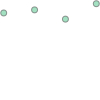

In [95]:
points_verticle_sort = MultiPoint([(0,0), (1,0.1), (2,-0.2), (3,0.3)])
points_verticle_sort

In [96]:
sorted_multi_point = sort_MultiPoint(points_verticle_sort, ascending = False, axis =0 )
for point in sorted_multi_point.geoms:
    print (point.coords[0])

(3.0, 0.3)
(2.0, -0.2)
(1.0, 0.1)
(0.0, 0.0)


### Line in polygon segmentation function

sorting multi point 
https://gis.stackexchange.com/questions/338460/reversing-coordinates-of-multipoint-using-shapely

In [97]:
def LineInPolygonSegmentation(input_line, input_polygon):
    '''
    Functionality:
        - to ouput the segment of a straight line inside and outside the polygon
        
        
    Input: LineString object representing a straight lines
    Ouput: Segments of lines. InSeg/OutSeg
    
    '''
    
    
    line_segment_in = [] # empty list to store the segment inside polygon
    line_segment_out = [] # empty list to store the segment outside the polygon
    
    
    #---Check if line is moving left-----
    #---to right or vice versa-----------
    #------------------------------------
    if (input_line.coords[0][0] < input_line.coords[1][0]): ### x1 < x2;
        isLeftToRight = True
        isVertical = False
        isRightToLeft = False
    elif ((input_line.coords[0][0] == input_line.coords[1][0])):   ### x1 = x2;
        isLeftToRight = False
        isVertical = True
        isRightToLeft = False
    else:                                                     ## x1 < x2
        isLeftToRight = False
        isVertical = False
        isRightToLeft = True
    
    
    #---------STEP 1:--------------------
    #---Get intersection point-----------
    #------------------------------------
    # a MultiPoint Object
    intersection_points = LinePolygonIntersectionPoints(input_line, input_polygon)
    
    ### check number of intersection points
    num_points = len(intersection_points.geoms)
    
    ## sort the multipoints in certain orders
    if (num_points != 0):
        if isLeftToRight: 
            # sort the points in x axis, ascending order
            intersection_point_sorted = sort_MultiPoint(intersection_points, ascending = True, axis = 0) 
        elif isVertical:
            # sort the points in y axis, ascending order
            intersection_point_sorted = sort_MultiPoint(intersection_points, ascending = True, axis = 1)
        elif isRightToLeft:
            # sort the points in x axis, descending order
            intersection_point_sorted = sort_MultiPoint(intersection_points, ascending = False, axis = 0)
            
    else:
        return None, None
            
    
    number_of_segments = num_points + 1
      
    #----------------------------------------------
    # Divide line into in-segemnts and out-segments
    # ---------------------------------------------
    #----------------------------------------------

    # from the first coordinate 
    currentSegmentIsIn = polygon.contains(Point([input_line.coords[0]]))
    
    for seg_point in range(num_points):
        #  LineString([(5, -23), (5, 23)]) object
          
        if (seg_point == 0):
            ## if current intersection point is the first point (closest to x1,y1)
            current_seg_line = LineString([Point([input_line.coords[0]]), 
                                           intersection_point_sorted.geoms[seg_point]])
                                          
        else:   
            current_seg_line = LineString([intersection_point_sorted.geoms[seg_point-1], 
                                           intersection_point_sorted.geoms[seg_point]]) 
                        
            if currentSegmentIsIn:
                # append current segment into the line_segment_in list
                line_segment_in.append(current_seg_line)
            else:
                line_segment_out.append(current_seg_line)
                                          
        currentSegmentIsIn = ~currentSegmentIsIn
    
    
    #-------------------------------------------------------------------------
#     ## add the last segment: (from last intersection point to x2, y2)
#     current_seg_line = LineString([intersection_point_sorted.geoms[seg_point], 
#                                    Point([input_line.coords[1]])]) 
    
#     if currentSegmentIsIn:
#         # append current segment into the line_segment_in list
#         line_segment_in.append(current_seg_line)
#     else:
#         line_segment_out.append(current_seg_line)
    #-------------------------------------------------------------------------
    
        
    line_segment_in = tuple(line_segment_in) 
    line_segment_out = tuple(line_segment_out)
    
    line_segment_in_mutiline = MultiLineString(line_segment_in)
    line_segment_out_mutiline = MultiLineString(line_segment_out)
    print (line_segment_in_mutiline)
    print ("\n")
    print (line_segment_out_mutiline)
    print ("\n")
    
    return line_segment_in_mutiline, line_segment_out_mutiline
    

In [98]:
line_segment_in_mutiline, line_segment_out_mutiline = LineInPolygonSegmentation(line_example, polygon)

MULTIPOINT (5.005434782608695 -20.5, 5.094565217391304 20.5, 5.079992385580981 13.79649736725153, 5.091360251393237 19.0257156408892, 5.010100644041152 -18.35370374107048, 5.021533710350291 -13.09449323886593)
MULTILINESTRING ((5.005434782608695 -20.5, 5.010100644041152 -18.35370374107048), (5.021533710350291 -13.09449323886593, 5.079992385580981 13.79649736725153), (5.091360251393237 19.0257156408892, 5.094565217391304 20.5))


MULTILINESTRING ((5.010100644041152 -18.35370374107048, 5.021533710350291 -13.09449323886593), (5.079992385580981 13.79649736725153, 5.091360251393237 19.0257156408892))




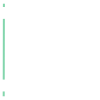

In [99]:
line_segment_in_mutiline

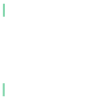

In [100]:
line_segment_out_mutiline

Saving figure Step10 -apply line polygon segmentation result 


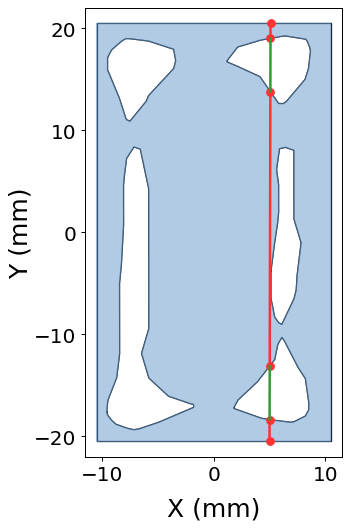

In [101]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)


ax = plt.axes()


plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)


#----------------------plot the example line------------------------------------------------------------
# plot_line(ax, ob=line_example, color=BLACK, zorder=1, linewidth=2, alpha=1)

#----------------------plot the intersection point----------------------------------------------------------
xs = [point.x for point in intersection_points.geoms]
ys = [point.y for point in intersection_points.geoms]
ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_segment_in_mutiline.geoms)):  
    plot_line(ax, ob=line_segment_in_mutiline.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)
    
for i in range (len(line_segment_out_mutiline.geoms)):  
    plot_line(ax, ob=line_segment_out_mutiline.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    
# plot_line(ax, ob=line_segment_in_mutiline.geoms[0], color=GREEN, zorder=10, linewidth=2, alpha=1)       
# plot_line(ax, ob=line_segment_out_mutiline.geoms[0], color=RED, zorder=10, linewidth=2, alpha=1)
# plot_line(ax, ob=line_segment_out_mutiline.geoms[1], color=RED, zorder=10, linewidth=2, alpha=1)
# plot_line(ax, ob=line_segment_out_mutiline.geoms[2], color=RED, zorder=10, linewidth=2, alpha=1)
    
    
patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)



# ax.set_title('Red Line-Inside polygon \n Green Line-Outside polygon or in Holes \n Red dots-intersection point')
save_fig("Step10 -apply line polygon segmentation result ")


## plot another example line intersection

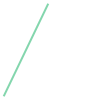

In [102]:
line_example2 = LineString ([(-10.1,-21),(10.1,21)])
line_example2

MULTIPOINT (-9.859523809523807 -20.5, 9.859523809523807 20.5, -8.954949344499807 -18.61920160737584, -6.192165132805279 -12.87479879098127, 6.076088612462458 12.6334515704665, 8.644412896090458 17.97353176414848)
MULTIPOINT (-9.859523809523807 -20.5, 9.859523809523807 20.5, -8.954949344499807 -18.61920160737584, -6.192165132805279 -12.87479879098127, 6.076088612462458 12.6334515704665, 8.644412896090458 17.97353176414848)
MULTILINESTRING ((-9.859523809523807 -20.5, -8.954949344499807 -18.61920160737584), (-6.192165132805279 -12.87479879098127, 6.076088612462458 12.6334515704665), (8.644412896090458 17.97353176414848, 9.859523809523807 20.5))


MULTILINESTRING ((-8.954949344499807 -18.61920160737584, -6.192165132805279 -12.87479879098127), (6.076088612462458 12.6334515704665, 8.644412896090458 17.97353176414848))




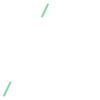

In [103]:
intersection_points2  = LinePolygonIntersectionPoints(line_example2, polygon)
line_segment_in_2, line_segment_out_2 = LineInPolygonSegmentation(line_example2, polygon)
line_segment_out_2

In [104]:
line_example3 = LineString ([(-11,-21),(-11,21)])
# intersection_points3  = LinePolygonIntersectionPoints(line_example3, polygon)
line_segment_in_3, line_segment_out_3 = LineInPolygonSegmentation(line_example3, polygon)
line_segment_out_3

GEOMETRYCOLLECTION EMPTY


Saving figure Step10 (2) -apply line polygon segmentation result 


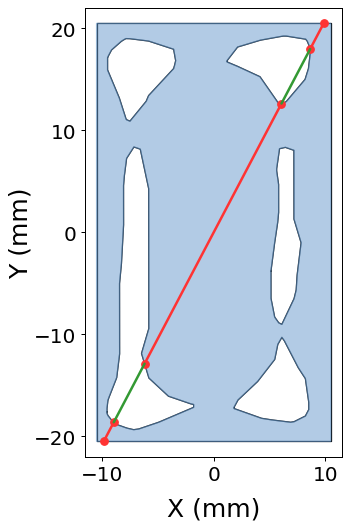

In [105]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()


plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)


#----------------------plot the intersection point----------------------------------------------------------
xs = [point.x for point in intersection_points2.geoms]
ys = [point.y for point in intersection_points2.geoms]
ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_segment_in_2.geoms)):  
    plot_line(ax, ob=line_segment_in_2.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)
    
for i in range (len(line_segment_out_2.geoms)):  
    plot_line(ax, ob=line_segment_out_2.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)



# ax.set_title('Red Line-Inside polygon \n Green Line-Outside polygon or in Holes \n Red dots-intersection point')
save_fig("Step10 (2) -apply line polygon segmentation result ")

## BufferM2 Algorithm: Computes buffer zone around a polygon

polygon.buffer(value)

value +
- make the hole smaller, 
- make the exterior countour bigger


value -
- make the hole bigger, 
- make the exterior countour smaller

#### Shapely buffer function 

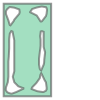

In [106]:
polygon.buffer(0)

In [107]:
polygon.interiors[0].coords

In [108]:
polygon.exterior.coords[0]

(-10.5, -20.5)

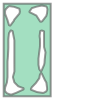

In [109]:
## buffer 0.2 unit (not in meters)
polygon_buffered = polygon.buffer(-0.2)
polygon_buffered

In [110]:
polygon_buffered.interiors[0].coords[0]

(1.0045809040451292, 16.773204997203752)

In [111]:
polygon_buffered.exterior.coords[0]

(-10.3, -20.3)

## Create Zig-Zag Tool Path

In [112]:
## Create lines and requried parameters
delta_x = 1    ## delta_x determines the intervals of lines in x direction

delta_y = 1000  ## the dx/dy determins the slope of the lines, larger delta_y gives more vertical lines


nl = 150 ## % Could probably calculate this

In [113]:
# poly_lines = list(polygon.exterior.coords)
x_countour = tuple([point.x for point in MultiPoint(polygon.exterior.coords)])
y_countour = tuple([point.y for point in MultiPoint(polygon.exterior.coords)])

In [114]:
print (x_countour)

(-10.5, 10.5, 10.5, -10.5, -10.5)


In [115]:
import math

# MATLAB:
# xe = floor(min(xc)./dx)*dx + (0:(nl-1))*dx;
# ye = sort(ceil(max(yc)./dy)*dy - (0:(nl-1))*dy);

x_extended = []
y_extended = []

# this means 0,1,2,.... nl-1, there are nl numbers in total
for n in range(nl): 
    # floor returns floor of x - the largest integer not greater than x
    xe = math.floor(min(x_countour) / delta_x) * delta_x + n * delta_x
    ye = math.ceil(max(y_countour) / delta_y) * delta_y - n *delta_y
    x_extended.append(xe)
    y_extended.append(ye)
    
y_extended.sort()

In [116]:
print (x_extended)

[-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138]


In [117]:
print (y_extended)

[-148000, -147000, -146000, -145000, -144000, -143000, -142000, -141000, -140000, -139000, -138000, -137000, -136000, -135000, -134000, -133000, -132000, -131000, -130000, -129000, -128000, -127000, -126000, -125000, -124000, -123000, -122000, -121000, -120000, -119000, -118000, -117000, -116000, -115000, -114000, -113000, -112000, -111000, -110000, -109000, -108000, -107000, -106000, -105000, -104000, -103000, -102000, -101000, -100000, -99000, -98000, -97000, -96000, -95000, -94000, -93000, -92000, -91000, -90000, -89000, -88000, -87000, -86000, -85000, -84000, -83000, -82000, -81000, -80000, -79000, -78000, -77000, -76000, -75000, -74000, -73000, -72000, -71000, -70000, -69000, -68000, -67000, -66000, -65000, -64000, -63000, -62000, -61000, -60000, -59000, -58000, -57000, -56000, -55000, -54000, -53000, -52000, -51000, -50000, -49000, -48000, -47000, -46000, -45000, -44000, -43000, -42000, -41000, -40000, -39000, -38000, -37000, -36000, -35000, -34000, -33000, -32000, -31000, -30000

In [118]:
y_extended[-1] # the last number from this list

1000

In [119]:
# convert the list to array
test_array = np.array([x_extended])
test_array.shape

(1, 150)

In [120]:
# convert to numpy array and also reverse the direction
test_array = np.array([y_extended[::-1]])
test_array.shape
# test_array

(1, 150)

In [121]:
# MATLAB
# xa = xe;
# ya = ones(1,nl).*ye(end);
# xb = ones(1,nl).*xe(1);
# yb = ye(end:-1:1); % Reverse the order of elements

# xl = [xa; xb];
# yl = [ya; yb];

'''
xa, ya gives a horizontal line y=1000, while x ranges from -11 to 137 (interval 1)

xb, yb gives a vertical line x = -11, while y ranges from 1000 to -147000 (interval 1000)
'''

xa = np.array([x_extended])
ya = np.ones((1, nl)) * y_extended[-1]
xb = np.ones((1, nl)) * x_extended[0]
yb = np.array([y_extended[::-1]])


xl = np.concatenate((xa, xb))
yl = np.concatenate((ya, yb))

In [122]:
xa

array([[-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138]])

In [123]:
xa.shape

(1, 150)

In [124]:
ya

array([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
      

In [125]:
ya.shape

(1, 150)

In [126]:
xb

array([[-11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., -11., -11., -11., -11., -11., -11.,
        -11., -11., -11., -11., -11., 

In [127]:
xb.shape

(1, 150)

In [128]:
yb

array([[   1000,       0,   -1000,   -2000,   -3000,   -4000,   -5000,
          -6000,   -7000,   -8000,   -9000,  -10000,  -11000,  -12000,
         -13000,  -14000,  -15000,  -16000,  -17000,  -18000,  -19000,
         -20000,  -21000,  -22000,  -23000,  -24000,  -25000,  -26000,
         -27000,  -28000,  -29000,  -30000,  -31000,  -32000,  -33000,
         -34000,  -35000,  -36000,  -37000,  -38000,  -39000,  -40000,
         -41000,  -42000,  -43000,  -44000,  -45000,  -46000,  -47000,
         -48000,  -49000,  -50000,  -51000,  -52000,  -53000,  -54000,
         -55000,  -56000,  -57000,  -58000,  -59000,  -60000,  -61000,
         -62000,  -63000,  -64000,  -65000,  -66000,  -67000,  -68000,
         -69000,  -70000,  -71000,  -72000,  -73000,  -74000,  -75000,
         -76000,  -77000,  -78000,  -79000,  -80000,  -81000,  -82000,
         -83000,  -84000,  -85000,  -86000,  -87000,  -88000,  -89000,
         -90000,  -91000,  -92000,  -93000,  -94000,  -95000,  -96000,
      

In [129]:
yb.shape

(1, 150)

In [130]:
xl.shape

(2, 150)

In [131]:
yl.shape

(2, 150)

## Integrate the grid line creation function

In [132]:
def grid_line_creation(polygon, delta_x = 1, delta_y = 1000, nl = 150):
    '''
    Input variables:
        - delta_x determines the intervals of lines in x direction
        - the dx/dy determins the slope of the lines, larger delta_y gives more vertical lines
        - nl: a hyperparameter determin the grid points
        - polygon: the input polygon
    
    Output:
        - line_elements: a list of lines (LineString objects)
    '''
    
    x_countour = tuple([point.x for point in MultiPoint(polygon.exterior.coords)]) # tuples, x coordinates of the polygon exterior contour
    y_countour = tuple([point.y for point in MultiPoint(polygon.exterior.coords)])
    
    # two empty list for temperarily store variables
    x_extended = []
    y_extended = []

    # this means 0,1,2,.... nl-1, there are nl numbers in total
    for n in range(nl): 
        # floor returns floor of x - the largest integer not greater than x
        xe = math.floor(min(x_countour) / delta_x) * delta_x + n * delta_x
        ye = math.ceil(max(y_countour) / delta_y) * delta_y - n *delta_y
        x_extended.append(xe)
        y_extended.append(ye)
    y_extended.sort() # sort the list in ascending order
    
    
    xa = np.array([x_extended])                 # shape is (1, nl)
    ya = np.ones((1, nl)) * y_extended[-1]      # shape is (1, nl)
    xb = np.ones((1, nl)) * x_extended[0]       # shape is (1, nl)
    yb = np.array([y_extended[::-1]])           # shape is (1, nl)


    xl = np.concatenate((xa, xb)) # shape should be (2, nl)
    yl = np.concatenate((ya, yb)) # shape should be (2, nl)
    
    
    ## create the LineString element based on the xl yl
    line_elements = []

    for i in range (nl):
        # example: line_element = LineString([(5, -23), (5.1, 23)])
        # xl(1,ii), yl(1,ii), xl(2,ii), yl(2,ii)
        line = LineString([(xl[0,i], yl[0,i]), (xl[1,i], yl[1,i])])
        line_elements.append(line)
        
    return line_elements


In [133]:
line_elements = grid_line_creation(polygon, delta_x = 1, delta_y = 1000, nl = 150)
line_elements2 = grid_line_creation(polygon, delta_x = 2, delta_y = 1000, nl = 150)
line_elements3 = grid_line_creation(polygon, delta_x = 1, delta_y = 5, nl = 150)
line_elements4 = grid_line_creation(polygon, delta_x = 2, delta_y = 2, nl = 150)
line_elements5 = grid_line_creation(polygon, delta_x = 4, delta_y = 4, nl = 150)
line_elements6 = grid_line_creation(polygon, delta_x = 2, delta_y = 0.5, nl = 150)


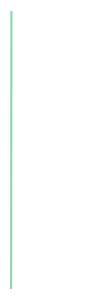

In [134]:
line_elements[1]

In [135]:
len(line_elements)

150

## visualize the line grid we created

Saving figure Step11 - Grid line creation


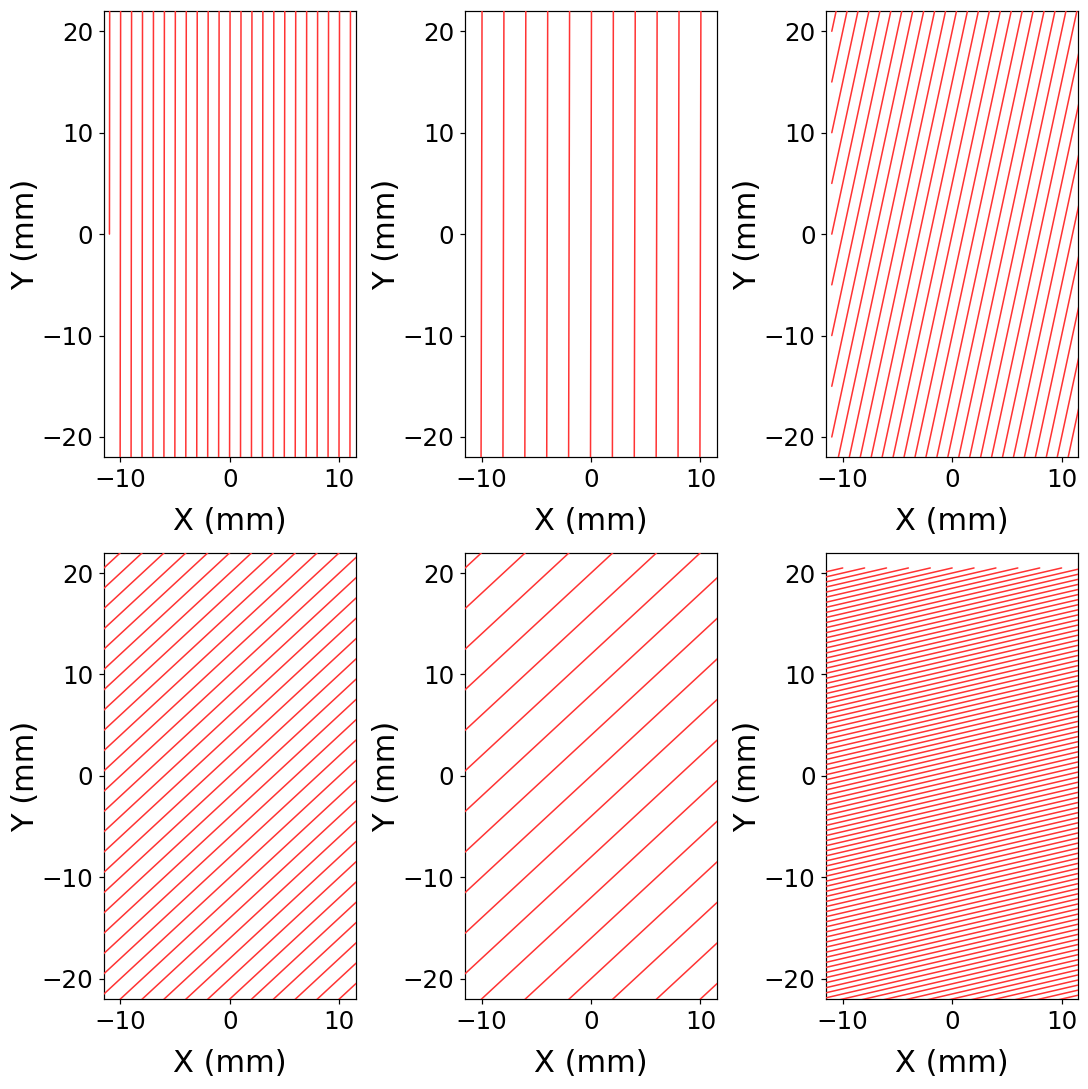

In [136]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(10, 10), dpi=110)


ax = fig.add_subplot(231)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements)):  
    plot_line(ax, ob=line_elements[i], color=RED, zorder=10, linewidth=1, alpha=1)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 1 \n delta_x = 1, delta_y = 1000 \n nl = 150')



ax = fig.add_subplot(232)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements2)):  
    plot_line(ax, ob=line_elements2[i], color=RED, zorder=10, linewidth=1, alpha=1)
    
ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 2 \n delta_x = 2, delta_y = 1000 \n nl = 150')

ax = fig.add_subplot(233)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements3)):  
    plot_line(ax, ob=line_elements3[i], color=RED, zorder=10, linewidth=1, alpha=1)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 3 \n delta_x = 1, delta_y = 5 \n nl = 150')


ax = fig.add_subplot(234)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements4)):  
    plot_line(ax, ob=line_elements4[i], color=RED, zorder=10, linewidth=1, alpha=1)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 4 \n delta_x = 2, delta_y = 2 \n nl = 150')



ax = fig.add_subplot(235)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements5)):  
    plot_line(ax, ob=line_elements5[i], color=RED, zorder=10, linewidth=1, alpha=1)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 5 \n delta_x = 4, delta_y = 4 \n nl = 150)')



ax = fig.add_subplot(236)
## --------------------plot intersection lines-------------------------------------------------------------
for i in range (len(line_elements6)):  
    plot_line(ax, ob=line_elements6[i], color=RED, zorder=10, linewidth=1, alpha=1)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Grid Line 6 \n delta_x = 2, delta_y = 0.5 \n nl = 150')


save_fig("Step11 - Grid line creation")

### Zig-zag the lines

In [137]:
line_segment_in, line_segment_out = LineInPolygonSegmentation(line_elements[2], polygon_buffered)

MULTIPOINT (-10.0203 -20.3, -9.979699999999999 20.3)
MULTILINESTRING ((-9.979699999999999 20.3, -10.0203 -20.3))


GEOMETRYCOLLECTION EMPTY




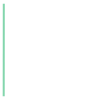

In [138]:
list_lines = []
for line in line_segment_in.geoms:
    list_lines.append(line)
    
list_line_reversed = list_lines[::-1]
reversed_segment = MultiLineString(tuple(list_line_reversed))
reversed_segment

In [139]:
def reverse_MultiLineString(multilinestring):
    '''
    This function reverse the Shapely MultiLineString Object
    
    Input/argument:
        - multilinestring: a shapely MultiLineString object
          
    Return : the MultiLineString object reversed
    '''
    
    list_lines = []
    for line in multilinestring.geoms:
        list_lines.append(line)

    list_line_reversed = list_lines[::-1]
    reversed_multilinestring = MultiLineString(tuple(list_line_reversed))
    return reversed_multilinestring

In [140]:
segment_inside_collection_test = [] # empty list
line_segment_in = reverse_MultiLineString(line_segment_in)
segment_inside_collection_test.append (line_segment_in)

line_segment_in2, line_segment_out2 = LineInPolygonSegmentation(line_elements[3], polygon_buffered)
segment_inside_collection_test.append (line_segment_in2)
segment_inside_collection_test

MULTIPOINT (-9.020300000000001 -20.3, -8.979699999999999 20.3, -9.018836135882887 -18.83613588288676, -9.014551095473415 -14.55109547341417, -8.98600292276781 13.99707723219078, -8.981668565900216 18.33143409978361)
MULTILINESTRING ((-8.979699999999999 20.3, -8.981668565900216 18.33143409978361), (-8.98600292276781 13.99707723219078, -9.014551095473415 -14.55109547341417), (-9.018836135882887 -18.83613588288676, -9.020300000000001 -20.3))


MULTILINESTRING ((-8.981668565900216 18.33143409978361, -8.98600292276781 13.99707723219078), (-9.014551095473415 -14.55109547341417, -9.018836135882887 -18.83613588288676))




In [141]:
# segment_inside_collection_test = MultiLineString(tuple(segment_inside_collection_test))

- polygon_buffered --- the output of bufferm2 function (shapely polygon.buffer function equivalent)
- xl, yl -- created lines

In [142]:
# line_elements = grid_line_creation(polygon, delta_x = 1, delta_y = 1000, nl = 150)

dirr = True
segment_inside_collection = [] # empty list

# from 0 to nl-1
for i in range (nl):
#     intersection_points2  = LinePolygonIntersectionPoints(line_example2, polygon_buffered)
    line_segment_in, line_segment_out = LineInPolygonSegmentation(line_elements[i], polygon_buffered)
    
    # if there is intersection between polygon and line
    if (line_segment_in is not None):
        if (dirr):
            segment_inside_collection.append (line_segment_in)
        else:
            segment_inside_collection.append (reverse_MultiLineString(line_segment_in))
        dirr = ~dirr

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
MULTIPOINT (-10.0203 -20.3, -9.979699999999999 20.3)
MULTILINESTRING ((-9.979699999999999 20.3, -10.0203 -20.3))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-9.020300000000001 -20.3, -8.979699999999999 20.3, -9.018836135882887 -18.83613588288676, -9.014551095473415 -14.55109547341417, -8.98600292276781 13.99707723219078, -8.981668565900216 18.33143409978361)
MULTILINESTRING ((-8.979699999999999 20.3, -8.981668565900216 18.33143409978361), (-8.98600292276781 13.99707723219078, -9.014551095473415 -14.55109547341417), (-9.018836135882887 -18.83613588288676, -9.020300000000001 -20.3))


MULTILINESTRING ((-8.981668565900216 18.33143409978361, -8.98600292276781 13.99707723219078), (-9.014551095473415 -14.55109547341417, -9.018836135882887 -18.83613588288676))


MULTIPOINT (-8.020300000000001 -20.3, -7.979699999999999 20.3, -8.019315033645222 -19.31503364522253, -7.992677242991834 7.322757008165674, -7.989041359288224 10.95864071177577, -7.980835

## Integrate the zig-zag line segmentation function

In [143]:
def zig_zag_segmentation(line_elements):
    '''
    Input
        - line_elements: a list object, contains a list of created grid lines (each element is a LineString object)
        
    Output:
        - segment_inside_collection: a list object, each element is a MultiLineString object containing the inside polygon portion of line
        - segment_outside_collection: a list, each element is a MultiLineStirng object containing outside portion of the line
        - intersection_points_collection: list, each element is a MultiPoint object containing the intersection point of lines and polygon
    '''
    
    # line_elements = grid_line_creation(polygon, delta_x = 1, delta_y = 1000, nl = 150)
    
    dirr = True
    dirr_out = True
    segment_inside_collection = [] # empty list for the inside portion of the lines
    segment_outside_collection = [] # empty list for the outside portion of the lines
    intersection_points_collection = [] # empty list for all intersection points

    # from 0 to nl-1
    for i in range (nl):
    #     intersection_points2  = LinePolygonIntersectionPoints(line_example2, polygon_buffered)
        intersection_points = LinePolygonIntersectionPoints(line_elements[i], polygon_buffered)
        line_segment_in, line_segment_out = LineInPolygonSegmentation(line_elements[i], polygon_buffered)
        
        if (len(intersection_points.geoms) != 0 ):
            intersection_points_collection.append(intersection_points)
#             if (dirr):
#                     segment_inside_collection.append (line_segment_in)
#             else:
#                 segment_inside_collection.append (reverse_MultiLineString(line_segment_in))
#             dirr = ~dirr
        

        # if there is intersection between polygon and line
        if (line_segment_in is not None):
            if (dirr):
                segment_inside_collection.append (line_segment_in)
            else:
                segment_inside_collection.append (reverse_MultiLineString(line_segment_in))
            dirr = ~dirr
            
        if (line_segment_out is not None):
            if (dirr_out):
                segment_outside_collection.append (line_segment_out)
            else:
                segment_outside_collection.append (reverse_MultiLineString(line_segment_out))
            dirr_out = ~dirr_out


                
    return segment_inside_collection, segment_outside_collection, intersection_points_collection

In [144]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
MULTIPOINT (-10.0203 -20.3, -9.979699999999999 20.3)
MULTIPOINT (-10.0203 -20.3, -9.979699999999999 20.3)
MULTILINESTRING ((-9.979699999999999 20.3, -10.0203 -20.3))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-9.020300000000001 -20.3, -8.979699999999999 20.3, -9.018836135882887 -18.83613588288676, -9.014551095473415 -14.55109547341417, -8.98600292276781 13.99707723219078, -8.981668565900216 18.33143409978361)
MULTIPOINT (-9.020300000000001 -20.3, -8.979699999999999 20.3, -9.018836135882887 -18.83613588288676, -9.014551095473415 -14.55109547341417, -8.98600292276781 13.99707723219078, -8.981668565900216 18.33143409978361)
MULTILINESTRING ((-8.979699999999999 20.3, -8.981668565900216 18.33143409978361), (-8.98600292276781 13.99707723219078, -9.014551095473415 -14.55109547341417), (-9.018836135882887 -18.83613588288676, -9.020300000000001 -20.3))


MULTILINESTRING ((-8.981668565900216 18.3314

## Visualize the final results

Saving figure Step11_Example1-Final Resut


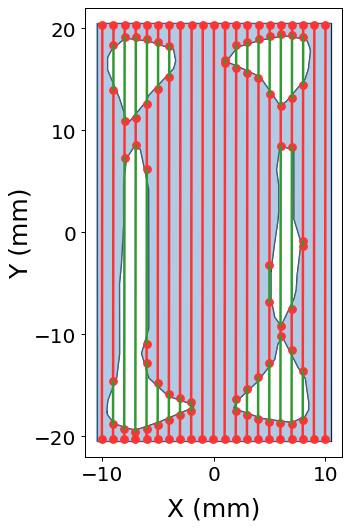

In [145]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()

#----------------------plot polygon with boundaries----------------------------------------------------------
plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

# segment_inside_collection, segment_out_collection, intersection_points_collection
#----------------------plot the intersection point----------------------------------------------------------
for intersection_points in intersection_points_collection:
    xs = [point.x for point in intersection_points.geoms]
    ys = [point.y for point in intersection_points.geoms]
#     ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=0.7, ms = 3)
    ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot segmented lines-------------------------------------------------------------
for in_seg in segment_inside_collection:
    for i in range (len(in_seg.geoms)):  
        plot_line(ax, ob=in_seg.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)

        
for out_seg in segment_out_collection:   
    for i in range (len(out_seg.geoms)):  
        plot_line(ax, ob=out_seg.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)


# ax.set_title('Red Line - Inside polygon \n Green Line - Outside polygon or in Holes \n Red dots - intersection point')

save_fig("Step11_Example1-Final Resut")

# Visaulization - Example 2 (change parameters dx)

In [146]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements2)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
MULTIPOINT (-10.0406 -20.3, -9.9594 20.3)
MULTIPOINT (-10.0406 -20.3, -9.9594 20.3)
MULTILINESTRING ((-9.9594 20.3, -10.0406 -20.3))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-8.0406 -20.3, -7.9594 20.3, -8.038615141941463 -19.30757097073155, -7.985319769844632 7.340115077684048, -7.978116656570911 10.94167171454471, -7.96164888894161 19.17555552919492)
MULTIPOINT (-8.0406 -20.3, -7.9594 20.3, -8.038615141941463 -19.30757097073155, -7.985319769844632 7.340115077684048, -7.978116656570911 10.94167171454471, -7.96164888894161 19.17555552919492)
MULTILINESTRING ((-7.9594 20.3, -7.96164888894161 19.17555552919492), (-7.978116656570911 10.94167171454471, -7.985319769844632 7.340115077684048), (-8.038615141941463 -19.30757097073155, -8.0406 -20.3))


MULTILINESTRING ((-7.96164888894161 19.17555552919492, -7.978116656570911 10.94167171454471), (-7.985319769844632 7.340115077684048, -8.0386151419

Saving figure Step11_Example2-Final Resut


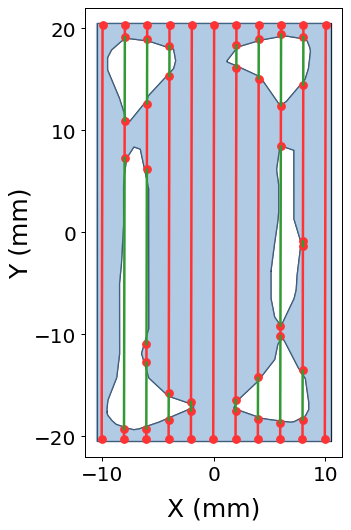

In [147]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()

#----------------------plot polygon with boundaries----------------------------------------------------------
plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

# segment_inside_collection, segment_out_collection, intersection_points_collection
#----------------------plot the intersection point----------------------------------------------------------
for intersection_points in intersection_points_collection:
    xs = [point.x for point in intersection_points.geoms]
    ys = [point.y for point in intersection_points.geoms]
#     ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1, ms = 4)
    ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot segmented lines-------------------------------------------------------------
for in_seg in segment_inside_collection:
    for i in range (len(in_seg.geoms)):  
        plot_line(ax, ob=in_seg.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)

        
for out_seg in segment_out_collection:   
    for i in range (len(out_seg.geoms)):  
        plot_line(ax, ob=out_seg.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Red Line - Inside polygon \n Green Line - Outside polygon or in Holes \n Red dots - intersection point')

save_fig("Step11_Example2-Final Resut")

In [148]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements4)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
MULTIPOINT (-10.3 19.7, -9.699999999999999 20.3)
MULTIPOINT (-10.3 19.7, -9.699999999999999 20.3)
MULTILINESTRING ((-9.699999999999999 20.3, -10.3 19.7))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-10.3 17.7, -7.699999999999999 20.3)
MULTIPOINT (-10.3 17.7, -7.699999999999999 20.3)
MULTILINESTRING ((-7.699999999999999 20.3, -10.3 17.7))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-10.3 15.7, -5.699999999999999 20.3, -9.710287805272552 16.28971219472745, -6.892693719982008 19.10730628001799)
MULTIPOINT (-10.3 15.7, -5.699999999999999 20.3, -9.710287805272552 16.28971219472745, -6.892693719982008 19.10730628001799)
MULTILINESTRING ((-5.699999999999999 20.3, -6.892693719982008 19.10730628001799), (-9.710287805272552 16.28971219472745, -10.3 15.7))


MULTILINESTRING ((-6.892693719982008 19.10730628001799, -9.710287805272552 16.28971219472745))


MULTIPOINT (-10.3 13.7, -3.699999999999999 20.3, -9

Saving figure Step11_Example3-Final Resut


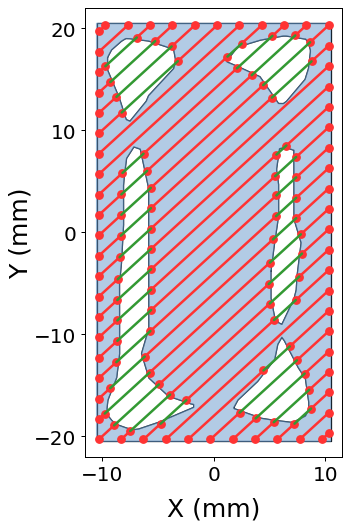

In [149]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()

#----------------------plot polygon with boundaries----------------------------------------------------------
plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

# segment_inside_collection, segment_out_collection, intersection_points_collection
#----------------------plot the intersection point----------------------------------------------------------
for intersection_points in intersection_points_collection:
    xs = [point.x for point in intersection_points.geoms]
    ys = [point.y for point in intersection_points.geoms]
#     ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1, ms = 4)
    ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot segmented lines-------------------------------------------------------------
for in_seg in segment_inside_collection:
    for i in range (len(in_seg.geoms)):  
        plot_line(ax, ob=in_seg.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)

        
for out_seg in segment_out_collection:   
    for i in range (len(out_seg.geoms)):  
        plot_line(ax, ob=out_seg.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Red Line - Inside polygon \n Green Line - Outside polygon or in Holes \n Red dots - intersection point')

save_fig("Step11_Example3-Final Resut")

In [150]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements5)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION EMPTY
MULTIPOINT (-10.3 17.7, -7.699999999999999 20.3)
MULTIPOINT (-10.3 17.7, -7.699999999999999 20.3)
MULTILINESTRING ((-7.699999999999999 20.3, -10.3 17.7))


GEOMETRYCOLLECTION EMPTY


MULTIPOINT (-10.3 13.7, -3.699999999999999 20.3, -9.267311682327202 14.7326883176728, -5.240402146318623 18.75959785368138)
MULTIPOINT (-10.3 13.7, -3.699999999999999 20.3, -9.267311682327202 14.7326883176728, -5.240402146318623 18.75959785368138)
MULTILINESTRING ((-3.699999999999999 20.3, -5.240402146318623 18.75959785368138), (-9.267311682327202 14.7326883176728, -10.3 13.7))


MULTILINESTRING ((-5.240402146318623 18.75959785368138, -9.267311682327202 14.7326883176728))


MULTIPOINT (-10.3 9.699999999999999, 0.3000000000000003 20.3, -8.248694701685846 11.75130529831415, -3.211743650024458 16.78825634997554)
MULTIPOINT (-10.3 9.699999999999999, 0.3000000000000003 20.3, -8.248694701685846 11.75130529831415, 

Saving figure Step11_Example5-Final Resut


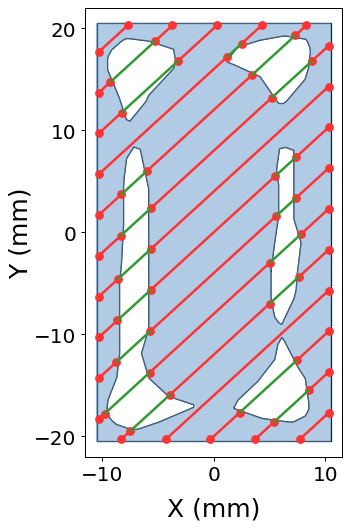

In [151]:
### visualization of the line polygon segmentation

fig = pyplot.figure(1, figsize=(4,6), dpi=90)
ax = plt.axes()

#----------------------plot polygon with boundaries----------------------------------------------------------
plot_line(ax, ob=polygon.exterior, color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[0], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[1], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[2], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[3], color=BLACK, zorder=1, linewidth=1, alpha=1)
plot_line(ax, ob=polygon.interiors[4], color=BLACK, zorder=1, linewidth=1, alpha=1)

# segment_inside_collection, segment_out_collection, intersection_points_collection
#----------------------plot the intersection point----------------------------------------------------------
for intersection_points in intersection_points_collection:
    xs = [point.x for point in intersection_points.geoms]
    ys = [point.y for point in intersection_points.geoms]
#     ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1, ms = 4)
    ax.plot(xs, ys, 'o', color=RED, zorder=10, alpha=1)
# ax.plot(intersection_points, 'o', color=RED, zorder=1, alpha=1)        


## --------------------plot segmented lines-------------------------------------------------------------
for in_seg in segment_inside_collection:
    for i in range (len(in_seg.geoms)):  
        plot_line(ax, ob=in_seg.geoms[i], color=RED, zorder=10, linewidth=2, alpha=1)

        
for out_seg in segment_out_collection:   
    for i in range (len(out_seg.geoms)):  
        plot_line(ax, ob=out_seg.geoms[i], color=GREEN, zorder=10, linewidth=2, alpha=1)
    
    

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-22, 22)
plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
plt.xticks([-10, 0, 10], fontsize = 16) 
plt.yticks([-20, -10, 0 , 10, 20], fontsize = 16)
# ax.set_title('Red Line - Inside polygon \n Green Line - Outside polygon or in Holes \n Red dots - intersection point')

save_fig("Step11_Example5-Final Resut")